# Analysis of regional mass balance

## Input
Input csv contains records for each RGI polygon, output of `mb_parallel.py` script

In [ ]:
%load_ext autoreload

In [164]:
%autoreload 2

In [165]:
from imview.lib import pltlib

In [166]:
pltlib.add_cbar?

In [2]:
#%matplotlib notebook
%matplotlib inline

In [157]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from imview.lib import pltlib

from osgeo import gdal
from pygeotools.lib import iolib, geolib, malib

import geopandas as gpd
import cartopy.crs as ccrs 

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 500)

In [4]:
fig_opt = {'dpi':300, 'bbox_inches':'tight', 'pad_inches':0}

# Spatial autocorrelation factor Acorf vs. glacier area A

785398.1633974483


Text(0, 0.5, 'Acorf')

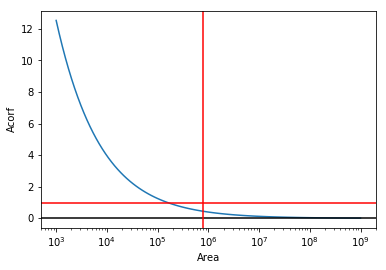

In [5]:
areaa = np.logspace(3, 9, 100)
L = 500
Acor = np.pi*(L**2)
print(Acor)
Acorf = np.sqrt(Acor/(5*areaa))
f,ax = plt.subplots()
ax.semilogx(areaa, Acorf)
ax.axhline(1.0, color='r')
ax.axhline(0.0, color='k')
ax.axvline(Acor, color='r')
ax.set_xlabel('Area')
ax.set_ylabel('Acorf')

In [6]:
def cartopy_extent(extent):
    return [extent[0], extent[2], extent[1], extent[3]]

def append_centroid_xy(df):
    xlist = []
    ylist = []
    for index, row in df.centroid.iteritems():
        xlist.append(row.x)
        ylist.append(row.y)
    df['centroid_x'] = xlist
    df['centroid_y'] = ylist

#Root sum of squared errors
def rss(a, c=0.0):
    #return ((a**2).sum() + c*a.prod())**0.5
    return ((a**2).sum())**0.5

#Root mean squared errors
def rms(a):
    return ((a**2).mean())**0.5

In [324]:
#Define aggregation function for the dissolve
def aggregate(glac_df, glac_df_mb, col):
    aggfunc = {'area_m2':[np.mean, np.sum], \
               'mb_mwea':[np.mean, np.median, np.std, np.sum, np.size], \
               'mb_mwea_sigma':[np.mean, np.sum, rss], \
               'mb_m3wea':[np.mean, np.median, np.sum], \
               'mb_m3wea_sigma':[np.mean, np.sum, rss, rms], \
               'mb_Gta':[np.sum], \
               'mb_Gta_sigma':[np.mean, np.sum, rss, rms], \
               'Area':[np.mean, np.sum], \
               't1':[np.mean, np.min, np.max], \
               't2':[np.mean, np.min, np.max], \
               'dt':[np.mean, np.min, np.max], \
               'z_med':[np.mean, np.median, np.min, np.max]}
    
    #This is for all glaciers - mostly just to get total area
    glac_df_agg_sum = glac_df.groupby(col).sum()
    glac_df_agg_mean = glac_df.groupby(col).mean()
    #glac_df_agg_mean = glac_df.groupby(col).median()
    #Perform the aggregation
    glac_df_mb_agg = glac_df_mb.groupby(col).agg(aggfunc)
    
    #This is count of number of glaciers
    glac_df_mb_agg[('mb_mwea', 'count')] = glac_df_mb_agg[('mb_mwea', 'size')].astype('int64')
    
    #Sigma for ('mb_mwea','mean'), assumign errors are dependent is ('mb_mwea_sigma', 'mean') - sum of errors divided by n samples
    #Sigma for ('mb_mwea','mean'), assuming errors for each glacier are independent, with equal weight
    glac_df_mb_agg[('mb_mwea_sigma', 'rss_mean')] = glac_df_mb_agg[('mb_mwea_sigma', 'rss')]/glac_df_mb_agg[('mb_mwea', 'count')]
    
    #These are values for all glaciers in each region (not just those with mb numbers)
    glac_df_mb_agg[('Area_all', 'mean')] = glac_df_agg_mean['Area']
    glac_df_mb_agg[('Area_all', 'sum')] = glac_df_agg_sum['Area']
    
    #Percent coverage of mb numbers
    glac_df_mb_agg[('Area','perc')] = 100*glac_df_mb_agg[('Area','sum')]/glac_df_mb_agg[('Area_all', 'sum')]
    glac_df_mb_agg[('mb_mwea', 'total_m3a')] = glac_df_mb_agg[('mb_mwea', 'mean')] * glac_df_mb_agg[('Area_all', 'sum')] * 1E6
    glac_df_mb_agg[('mb_mwea', 'total_Gta')] = glac_df_mb_agg[('mb_mwea', 'total_m3a')]/1E9 
    
    #Gta and Gta_sigma estimate converted to m_wea
    glac_df_mb_agg[('mb_mwea', 'Gta_to_mwea')] = 1000*glac_df_mb_agg[('mb_Gta','sum')]/glac_df_mb_agg[('Area', 'sum')]
    glac_df_mb_agg[('mb_mwea_sigma', 'Gta_to_mwea')] = 1000*glac_df_mb_agg[('mb_Gta_sigma','sum')]/glac_df_mb_agg[('Area', 'sum')]
    
    #Cumulative numbers for full time period
    glac_df_mb_agg[('mb_mwe_cum', 'mean')] = glac_df_mb_agg[('mb_mwea','mean')] * glac_df_mb_agg[('dt', 'mean')]
    glac_df_mb_agg[('mb_mwe_cum', 'total_m3')] = glac_df_mb_agg[('mb_mwea', 'total_m3a')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('mb_mwe_cum', 'total_Gt')] = glac_df_mb_agg[('mb_mwea', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
   
    #Compute numbers for meltwater (polygons with mb < 0)
    #glac_df_mb_agg_meltwater = glac_df_mb[glac_df_mb['mb_mwea' < 0]].sum()
    glac_df_mb_agg_meltwater = glac_df_mb[glac_df_mb['mb_m3wea'] < 0].groupby(col).agg(aggfunc)
    glac_df_mb_agg[('meltwater', 'count')] = glac_df_mb_agg_meltwater[('mb_mwea', 'size')].astype('int64') 
    glac_df_mb_agg[('meltwater', 'total_m3a')] = glac_df_mb_agg_meltwater[('mb_m3wea', 'sum')]
    glac_df_mb_agg[('meltwater', 'total_m3a_sigma')] = glac_df_mb_agg_meltwater[('mb_m3wea_sigma', 'sum')]
    glac_df_mb_agg[('meltwater', 'total_Gta')] = glac_df_mb_agg[('meltwater', 'total_m3a')]/1E9 
    glac_df_mb_agg[('meltwater', 'total_Gta_sigma')] = glac_df_mb_agg[('meltwater', 'total_m3a_sigma')]/1E9
    glac_df_mb_agg[('meltwater', 'total_mmSLEa')] = glac_df_mb_agg[('meltwater', 'total_Gta')]/Gt2mm
    glac_df_mb_agg[('meltwater', 'total_mmSLEa_sigma')] = glac_df_mb_agg[('meltwater', 'total_Gta_sigma')]/Gt2mm
    
    #Cumulative meltwater numbers for full time period
    glac_df_mb_agg[('meltwater_cum', 'total_m3')] = glac_df_mb_agg[('meltwater', 'total_m3a')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('meltwater_cum', 'total_Gt')] = glac_df_mb_agg[('meltwater', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('meltwater_cum', 'total_mmSLE')] = glac_df_mb_agg[('meltwater', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
    return glac_df_mb_agg

In [325]:
def spatial_aggregate(glac_df, glac_df_mb, agg_df, col, sort=True):
    glac_df_mb_agg = aggregate(glac_df, glac_df_mb, col)
    append_centroid_xy(agg_df)
    if 'basin' in col:
        #Preserve basin attributes (endorheic flag, discharge)
        glac_df_mb_agg = glac_df_mb_agg.merge(agg_df[['ENDO', 'centroid_x', 'centroid_y']], left_index=True, right_index=True)
    else:
        glac_df_mb_agg = glac_df_mb_agg.merge(agg_df[['centroid_x', 'centroid_y']], left_index=True, right_index=True)
    if sort:
        glac_df_mb_agg.sort_values(by=('Area_all', 'sum'), ascending=False, inplace=True)
    glac_df_mb_agg.df_name = col
    return glac_df_mb_agg

In [9]:
def add_legend(ax, sf=16, loc='upper right'):
    """
    Create legend for scaled scatterplot markers
    """
    ax.autoscale(False)
    #CONUS
    #leg_s = np.array([0.1, 0.5, 1.0, 5.0, 10.0])
    #HMA
    #leg_s = np.array([0.1, 1.0, 10.0, 100.0])
    leg_s = np.array([1.0, 10.0, 100.0, 1000.0, 10000.0])
    #Spoof dummy coordinates way off map
    leg_x = np.full(leg_s.size, -999999999)
    leg_y = np.full(leg_s.size, -999999999)
    for i, s in enumerate(leg_s):
        #lbl = r'$%0.1f\/km^2$' % s
        lbl = '%i' % s
        ax.scatter(leg_x[i], leg_y[i], s=s*sf, c='gray', label=lbl)
    legend = ax.legend(title=r'$Glacier\/Area\/(km^2)$', scatterpoints=1, loc=loc, prop={'size':7}, ncol=leg_s.size)
    legend.get_title().set_fontsize('8')
    return legend

In [153]:
def make_map(mb_dissolve_df=None, glac_df_mb=None, agg_df=None, col=('mb_mwea', 'mean'), sigma_col=None, \
             border_df=None, crs=None, extent=None, hs=None, hs_extent=None, clim=None, \
             labels='val', title=None):

    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_aspect('equal')
    legend = add_legend(ax, sf=scaling_f)
    if title is not None:
        ax.set_title(title)

    if clim is None:
        #clim = (glac_df_mb[col].min(), glac_df_mb[col].max())
        clim = malib.calcperc_sym(mb_dissolve_df[col], perc=(1,99))

    cmap = 'RdBu'
    label = None
    if 'mb_mwea' in col:
        label = 'Mass Balance (m we/yr)'
    elif 'mb_mwea_sigma' in col:
        cmap = 'inferno'
        label = 'Mass Balance Uncertainty (m we/yr)'
    elif 'mb_Gta' in col: 
        label = 'Mass Balance (Gt/yr)'
    elif 'mb_Gta_sigma' in col:
        cmap = 'inferno'
        label = 'Mass Balance Uncertainty (Gt/yr)'
    elif 'meltwater_Gta' in col: 
        label = 'Excess Meltwater Runoff (Gt/yr)'
        #Reverse, as these are negative values
        cmap = 'YlOrRd_r'
        #cmap = 'inferno'
        clim = malib.calcperc(mb_dissolve_df[col], perc=(0,99))
    elif 't1' in col:
        cmap = 'inferno'
        label = 'Source Date (year)'

    #This is cartopy-enabled axes
    #ax = plt.axes(projection=crs)

    #Currently unsupported for AEA
    #gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    if hs is not None:
        print("Plotting image")
        hs_style = {'cmap':'gray', 'origin':'upper', 'extent':cartopy_extent(hs_extent), 'transform':crs}
        ax.imshow(hs, **hs_style)

    if border_df is not None:
        print("Plotting borders")
        border_style = {'facecolor':'0.65','edgecolor':'k', 'linewidth':0.7}
        border_df.plot(ax=ax, **border_style)

    if False:
        if agg_df is not None:
            print("Plotting agg boundaries")
            #This provides colored regions
            #agg_style = {'cmap':'cpt_rainbow', 'edgecolor':'none', 'linewidth':0, 'alpha':0.05}
            agg_style = {'cmap':'summer', 'edgecolor':'none', 'linewidth':0, 'alpha':0.05}
            #agg_style = {'facecolor':'0.95','edgecolor':'k', 'linewidth':0.3, 'alpha':0.2}
            agg_df.plot(ax=ax, **agg_style)

    if glac_df_mb is not None:
        print("Plotting glacier polygons")
        glac_style = {'edgecolor':'k', 'linewidth':0.1, 'alpha':0.3}
        #This plots mb color ramp for each glacier polygon
        #glac_ax = glac_df_mb.plot(ax=ax, column=col[0], cmap=cmap, vmin=clim[0], vmax=clim[1], **glac_style)
        #This plots outlines
        glac_ax = glac_df_mb.plot(ax=ax, facecolor='none', **glac_style)

    if agg_df is not None:
        agg_style = {'facecolor':'none', 'edgecolor':'w', 'linewidth':0.5}
        agg_df.plot(ax=ax, **agg_style)

    #https://stackoverflow.com/questions/36008648/colorbar-on-geopandas
    # fake up the array of the scalar mappable so we can plot colorbar. Urgh...
    sc = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=clim[0], vmax=clim[1]))
    sc._A = []

    if mb_dissolve_df is not None:
        print("Plotting scatterplot of %s values" % (col, ))
        #Plot single values for region or basin
        x = mb_dissolve_df['centroid_x']
        y = mb_dissolve_df['centroid_y']
        #Scale by total glacier area in each polygon 
        if 'Area_all' in mb_dissolve_df:
            area_col = 'Area_all'
        elif ('Area_all', 'sum') in mb_dissolve_df:    
            area_col = ('Area_all', 'sum')
        elif ('Area_all', 'sum', 'sum') in mb_dissolve_df:
            area_col = ('Area_all', 'sum', 'sum')

        s = scaling_f*mb_dissolve_df[area_col]
        
        c = mb_dissolve_df[col]
        sc_style = {'cmap':cmap, 'edgecolor':'k', 'linewidth':0.5, 'alpha':0.8}
        sc = ax.scatter(x, y, s, c, vmin=clim[0], vmax=clim[1], **sc_style) 
        #Add labels
        text_kw = {'family':'sans-serif', 'fontsize':10, 'color':'k'}
        if labels is not None:
            print("Adding annotations")
            for k, v in mb_dissolve_df.iterrows():
                if 'sigma' in labels and sigma_col is not None:
                    if labels == 'val+sigma':
                        #sigma_col=('mb_Gta_sigma', 'sum', 'rss')
                        lbl = '%0.2f\u00b1%0.2f' % (v[col], v[sigma_col])
                    elif labels == 'name+val+sigma':
                        #sigma_col=('mb_Gta_sigma', 'sum', 'rss')
                        lbl = '%s\n%0.2f\u00b1%0.2f' % (k, v[col], v[sigma_col])
                else:
                    if 'name' in labels:
                        lbl = '%s\n%+0.2f' % (k, v[col])
                    else:
                        lbl = '%+0.2f' % v[col]
                #ax.annotate(lbl, xy=(v['centroid_x'],v['centroid_y']), xytext=(1,0), textcoords='offset points', family='sans-serif', fontsize=6, color='darkgreen')
                txt = ax.annotate(lbl, xy=(v['centroid_x'],v['centroid_y']), ha='center', va='center', **text_kw)
                txt.set_path_effects([path_effects.Stroke(linewidth=0.75, foreground='w'),path_effects.Normal()])

    #This is minx, miny, maxx, maxy
    if extent is None:
        #if glac_df_mb is not None:
        #    extent = glac_df_mb.total_bounds
        #else:
        extent = mb_dissolve_df.total_bounds

    #For cartopy axes
    #ax.set_extent(cartopy_extent(extent), crs=crs)
    #Pad extent so labels fit within map
    #extent = geolib.pad_extent(extent, perc=0.01, uniform=True)
    ax.set_xlim(extent[0], extent[2])
    ax.set_ylim(extent[1], extent[3])

    #Adding colorbar doesn't work with the cartopy axes
    pltlib.add_cbar(ax, sc, arr=mb_dissolve_df[col], label=label, clim=clim, format='%0.2f')
    pltlib.add_scalebar(ax, res=1)
    pltlib.hide_ticks(ax)

    plt.tight_layout()

    return fig

In [690]:
site = 'hma'
#site = 'conus'

area_filter = False
min_area_m2 = 1E6

outlier_removal = False

#Ocean area
#3.625×108 km2 (Cogley et al., 2011)
Gt2mm = 362.5

plot = True 
map_plots = True 

#Default mb clim
#mb_clim = (-1.0, 1.0)
#mb_clim = (-1.2, 1.2)
mb_clim = (-0.75, 0.75)

#suptitle = "Glacier Mass Balance (ASTER 2000–2009)"
suptitle = "Glacier Mass Balance (ASTER+WV/GE 2000–2018)"
#suptitle = "Glacier Mass Balance (ASTER 2009–2018)"
#suptitle = "Glacier Mass Balance (SRTM 2000 to WV/GE median)"

#HMA
scaling_f = 0.2 
#CONUS
#scaling_f = 3 

rgi_col = 'RGIId'
kaab_region_col = 'kaab_region'
region_col = 'himap_region'
basin_col = 'HYBAS_ID'
#basin_col = 'basin_name'
qdgc_col = 'qdgc'
mascon_col = 'mascon'
hex_col = 'id'

extent = None
crs = None
if site == 'hma':
    #WBM basin names
    basin_col = 'basin_name'
    hs_fn = '/Users/dshean/Documents/UW/HMA/mos/hma_mos_32m_20180723/hma_mos_32m_100m_hs_az315.tif'
    glac_shp_fn = '/Users/dshean/data/rgi60/regions/rgi60_merge_HMA_aea.shp'
    #glac_shp_fn = '/Users/dshean/data/rgi60/regions/rgi60_merge_HMA_aea_0.1km.shp'
    #glac_shp_fn = '/Users/dshean/data/rgi60/regions/rgi60_merge_HMA_aea_1km.shp'
    border_shp_fn = '/Users/dshean/data/NaturalEarth/10m_cultural/10m_cultural/ne_10m_admin_0_countries_lakes.shp'
    #basin_shp_fn = '/Users/dshean/data/HydroBASINS/hybas_lake_as_lev01-12_v1c/hybas_lake_as_lev04_v1c.shp'
    basin_shp_fn = '/Users/dshean/data/HydroBASINS/HiMAT_full_210_IDs_subset_merged_clip_names_update.gpkg'
    #region_shp_fn = '/Users/dshean/Documents/UW/HMA/Kaab_regions/regions_from_kaab2015_merged_clean.shp'
    kaab_region_shp_fn = '/Users/dshean/data/Kaab_regions/regions_from_kaab2015_merged_clean_20181111.gpkg'
    region_shp_fn = '/Users/dshean/data/himap_regions/boundary_mountain_regions_hma_v3_clean.gpkg'
    #http://www.mindland.com/wp/download-qdgc-continents/
    qdgc_shp_fn = '/Users/dshean/data/qdgc/qdgc_asia/qdgc_01_asia.shp'
    mascon_shp_fn = '/Users/dshean/data/grace_mascons/GSFC.glb.200301_201607_v02.4_clip.gpkg'
    hex_shp_fn = '/Users/dshean/data/hma_hexagons/hma_25km_hexagons.gpkg'
    #This is geopandas crs format
    glac_crs = {u'datum':u'WGS84',u'lat_0':36,u'lat_1':25,u'lat_2':47,u'lon_0':85,u'no_defs':True,u'proj':u'aea',u'units':u'm',u'x_0':0,u'y_0':0}
    #minx, miny, maxx, maxy
    extent = [-1610900, -1142400, 1767400, 1145700]
elif site == 'conus':
    #hs_fn = '/scr/mb/gpd/conus_20171018_mos_32m_trans_100m_hs_az315_1km.tif'
    glac_shp_fn = '/Users/dshean/data/rgi60/regions/rgi60_merge_CONUS_aea.shp'
    #region_shp_fn = '/Users/dshean/Documents/UW/CONUS/regions/conus_mb_regions.shp'
    region_shp_fn = '/Users/dshean/data/CONUS/regions/conus_mb_regions_aea.shp'
    border_shp_fn = '/Users/dshean/data/NaturalEarth/10m_cultural/10m_cultural/ne_10m_admin_1_states_provinces_lakes.shp'
    basin_shp_fn = '/Users/dshean/data/HydroBASINS/hybas_lake_na_lev01-12_v1c/hybas_lake_na_lev07_v1c.shp'
    glac_crs = {u'datum':u'WGS84',u'lat_0':43,u'lat_1':36,u'lat_2':49,u'lon_0':-115,u'no_defs':True,u'proj':u'aea',u'units':u'm',u'x_0':0,u'y_0':0}
    #This is cartopy
    crs = ccrs.AlbersEqualArea(central_longitude=-115, central_latitude=43, standard_parallels=(36, 49))
    extent = [-856800, -789000, 910700, 839400]
else:
    sys.exit("Site not currently supported")

In [12]:
def proc_rgi(glac_shp_fn, pointgeom=True):
    glac_df = gpd.read_file(glac_shp_fn)
    glac_df.shape
    glac_df.set_index(rgi_col, inplace=True)
    #Add centroid field - needed for proper partitioning in spatial join
    if pointgeom:
        glac_df['centroid_geom'] = gpd.GeoSeries(glac_df.centroid)
        glac_df['polygon_geom'] = gpd.GeoSeries(glac_df.geometry)
        glac_df.set_geometry('centroid_geom', inplace=True, drop=True)
    return glac_df

In [68]:
#Input csv from mb_parallel.py
#mb_csv_fn = sys.argv[1]
#mb_csv_fn = "/scr/hma/mb_20181108/ASTER_2000-2018/hma_mb_20181108_0454.csv"
#mb_csv_fn = "/scr/hma/mb_20181211/hma_mb_20181211_2117.csv"
#mb_csv_fn = "/scr/hma/mb_20181222/hma_mb_20181211_2117.csv"
#mb_csv_fn = "/scr/hma/mb_20190207/hma_mb_20190207_0856.csv"
#mb_csv_fn = "/scr/hma/mb_20190212/hma_mb_20190213_0143.csv"
#This is std
#mb_csv_fn = "/scr/hma/mb_20190213/hma_mb_20190213_1924.csv"
#This is nmad
#mb_csv_fn = "/scr/hma/mb_20190213_nmad/hma_mb_20190214_1015.csv"
mb_csv_fn = "/scr/hma/mb_20190213_nmad_hex/hma_mb_20190214_1015_nmad.csv"
#This is std + mean
#mb_csv_fn = "/scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean.csv"
#Copy for hex analysis
#mb_csv_fn = "/scr/hma/mb_20190213_std_sys_hex/hma_mb_20190215_0815_std+mean.csv"

#driver = 'GeoJSON'
#ext = 'geojson'
#driver = 'ESRI Shapefile'
#ext = 'shp'
driver = 'GPKG'
ext= 'gpkg'

merge_fn = os.path.splitext(mb_csv_fn)[0]+'_'+os.path.splitext(os.path.split(glac_shp_fn)[-1])[0]+'.'+ext

glac_shp_join_fn = os.path.splitext(merge_fn)[0]+'_join.'+ext

if os.path.exists(glac_shp_join_fn):
    print("Loading glacier polygons joined with regions, basins, qdgc, mascons")
    glac_df = gpd.read_file(glac_shp_join_fn)
    #This is a hack, as geojson doesn't properly preserve custom aae proj
    glac_df.crs = glac_crs
else:
    print("Loading glacier polygons from RGI")
    glac_df = proc_rgi(glac_shp_fn)

#Area in km2
#glac_df.geometry.area.sum()/1E6
#glac_df['Area'].sum()

if border_shp_fn is not None:
    print("Loading borders")
    #Load local copy of border polygons
    border_df = gpd.read_file(border_shp_fn)
    border_df = border_df.to_crs(glac_df.crs)

if kaab_region_shp_fn is not None:
    print("Loading Kaab regions")
    kaab_region_df = gpd.read_file(kaab_region_shp_fn)
    #Convert to glac crs
    kaab_region_df = kaab_region_df.to_crs(glac_df.crs)
    kaab_region_df.set_index(kaab_region_col, inplace=True)

if region_shp_fn is not None:
    print("Loading regions")
    region_df = gpd.read_file(region_shp_fn)
    #Convert to glac crs
    region_df = region_df.to_crs(glac_df.crs)
    region_df.set_index(region_col, inplace=True)

if basin_shp_fn is not None:
    print("Loading basins")
    basin_df = gpd.read_file(basin_shp_fn)
    #There are issues with fiona writing large integers in basin IDs, convert to string to be safe
    #The dtype is int64, but finoa writes int32, and they all get truncated to 2147483647
    if basin_col == 'HYBAS_ID':
        for f in ['HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS']:
            basin_df[f] = basin_df[f].astype('str')
    #Convert to glac crs
    basin_df = basin_df.to_crs(glac_df.crs)
    basin_df.set_index(basin_col, inplace=True)

if mascon_shp_fn is not None:
    print("Loading mascon")
    mascon_df = gpd.read_file(mascon_shp_fn)
    #Convert to glac crs
    mascon_df = mascon_df.to_crs(glac_df.crs)
    #Add a unique identifier
    mascon_df[mascon_col] = mascon_df.lat_center.map('{:,.0f}N'.format) + mascon_df.lon_center.map('{:,.0f}E'.format)
    mascon_df.set_index(mascon_col, inplace=True)

if qdgc_shp_fn is not None:
    print("Loading qdgc")
    qdgc_df = gpd.read_file(qdgc_shp_fn)
    #Convert to glac crs
    qdgc_df = qdgc_df.to_crs(glac_df.crs)
    qdgc_df.set_index(qdgc_col, inplace=True)
    
if hex_shp_fn is not None:
    print("Loading hex")
    hex_df = gpd.read_file(hex_shp_fn)
    #Convert to glac crs
    hex_df = hex_df.to_crs(glac_df.crs)
    hex_df.set_index(hex_col, inplace=True)

print(glac_df.shape)
#Add region, basin, etc fields to RGI polygons
if not os.path.exists(glac_shp_join_fn):
    if mascon_shp_fn is not None:
        print("One-time spatial join by mascon")
        glac_df = gpd.sjoin(glac_df, mascon_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':mascon_col}, inplace=True)
        print(glac_df.shape)

    if qdgc_shp_fn is not None:
        print("One-time spatial join by qdgc")
        glac_df = gpd.sjoin(glac_df, qdgc_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':qdgc_col}, inplace=True)
        print(glac_df.shape)
    
    if hex_shp_fn is not None:
        print("One-time spatial join by hex")
        glac_df = gpd.sjoin(glac_df, hex_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':hex_col}, inplace=True)
        print(glac_df.shape)

    if kaab_region_shp_fn is not None:
        print("One-time spatial join by Kaab region")
        glac_df = gpd.sjoin(glac_df, kaab_region_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':kaab_region_col}, inplace=True)
        print(glac_df.shape)
        
    if region_shp_fn is not None:
        print("One-time spatial join by region")
        glac_df = gpd.sjoin(glac_df, region_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':region_col}, inplace=True)
        print(glac_df.shape)

    if basin_shp_fn is not None:
        print("One-time spatial join by basin")
        glac_df = gpd.sjoin(glac_df, basin_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':basin_col}, inplace=True)
        print(glac_df.shape)

    glac_df.set_geometry('polygon_geom', inplace=True, drop=True)
    print("Writing out: %s" % glac_shp_join_fn)
    #With index set to RGIId, it is not written out, hack to create new column
    glac_df.reset_index().rename(columns={'index':rgi_col}).to_file(glac_shp_join_fn, driver=driver)

Loading glacier polygons joined with regions, basins, qdgc, mascons
Loading borders
Loading Kaab regions
Loading regions
Loading basins
Loading mascon
Loading qdgc
Loading hex
(94827, 47)


In [170]:
print("Loading mb")
mb_df = pd.read_csv(mb_csv_fn)
mb_df[rgi_col] = 'RGI60-'+mb_df[rgi_col].map('{:08.5f}'.format)
mb_df.set_index(rgi_col, inplace=True)
mb_df['mb_Gta'] = mb_df['mb_m3wea']/1E9
mb_df['mb_Gta_sigma'] = mb_df['mb_m3wea_sigma']/1E9

#Update uncertainty for specific mass balance numbers
#mb_df['mb_mwea_sigma_full'] = mb_df['mb_m3wea_sigma']/mb_df['area_m2']

mb_df_t1 = mb_df['t1'].mean()
mb_df_t2 = mb_df['t2'].mean()
print(mb_df_t1, mb_df_t2)
dt_str = '%.0f-%.0f' % (mb_df_t1, mb_df_t2)

#mb_df['mb_mwea_area'] = mb_df['mb_mwea'] * mb_df['area_km2']*1E6

if os.path.exists(merge_fn):
    print("Loading merged polygons and mb")
    glac_df_mb = gpd.read_file(merge_fn)
    glac_df_mb.set_index(rgi_col, inplace=True)
    print(glac_df_mb.shape)
else:
    print("Merging glacier polygons and mb results")
    glac_df_mb = glac_df.merge(mb_df, left_index=True, right_index=True)
    #With index set to RGIId, it is not written out, hack to create new column
    print(glac_df_mb.shape)
    print("Writing out: %s" % merge_fn)
    glac_df_mb.reset_index().rename(columns={'index':rgi_col}).to_file(merge_fn, driver=driver)

print("%i merged records loaded" % (glac_df_mb.shape[0]))

if area_filter:
    print("Filtering by glacier polygon area (min %0.2f km^2)" % (min_area_m2/1E6))
    orig_count = glac_df_mb.shape[0]
    glac_df_mb = glac_df_mb[glac_df_mb['area_m2'] > min_area_m2]
    print("%i of %i records preserved" % (glac_df_mb.shape[0], orig_count))

Loading mb
2000.4119999999998 2018.4119999999998
Loading merged polygons and mb
(94436, 72)
94436 merged records loaded


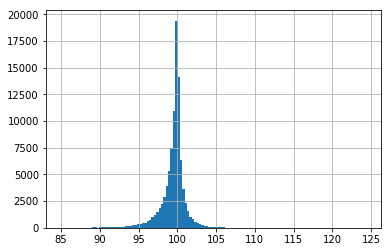

In [851]:
mb_df['valid_area_perc'].hist(bins=128)

In [862]:
np.percentile(mb_df['valid_area_perc'], 5)

96.617

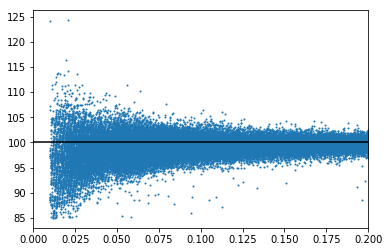

In [875]:
f,ax = plt.subplots()
ax.scatter(mb_df['area_m2']/1E6, mb_df['valid_area_perc'], s=1)

ax.set_xlim(0,0.2)
ax.axhline(100,color='k')

## Total glacier area covered

In [171]:
#MB total area
mb_area = glac_df_mb.area.sum()/1E6
#RGI total area
rgi_area = glac_df['Area'].sum()
#rgi_area = glac_df.area.sum()/1E6
print('MB area: %0.2f km^2' % mb_area)
print('RGI area: %0.2f km^2' % rgi_area)
print('Percent coverage: %0.2f%%' % (100*mb_area/rgi_area))

MB area: 97002.70 km^2
RGI area: 97300.12 km^2
Percent coverage: 99.69%


In [172]:
#Total RGI glacier count
rgi_count = 95608 - 72 #some RGI 10 included in our gpkg
mb_count = glac_df_mb.shape[0]
print('MB count: %i' % mb_count)
print('RGI count: %i' % rgi_count)
print('Percent coverage: %0.2f%%' % (100*mb_count/rgi_count))

MB count: 94436
RGI count: 95536
Percent coverage: 98.85%


## Sort by area

In [45]:
glac_df_mb_sort = glac_df_mb.sort_values(by='area_m2', ascending=False)

(-2, 2)

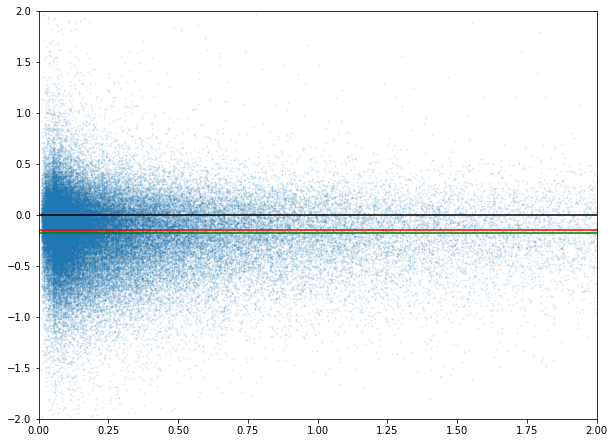

In [515]:
f,ax = plt.subplots(figsize=(10,7.5))
ax.scatter(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], s=1, alpha=0.1)
ax.axhline(0,c='k')
ax.axhline(glac_df_mb_sort['mb_mwea'].median(),c='r')
ax.axhline(glac_df_mb_sort['mb_mwea'].mean(),c='g')
ax.set_xlim(0,2)
ax.set_ylim(-2, 2)

(0, 100)

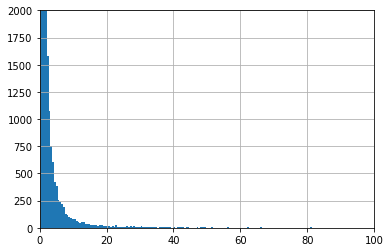

In [413]:
ax = glac_df_mb_sort['Area'].hist(bins=2000)
ax.set_ylim(0,2000)
ax.set_xlim(0,100)

In [445]:
import scipy.stats
from pygeotools.lib import malib

In [728]:
area_thresh = 0.1
small_idx = glac_df_mb_sort['Area'] < area_thresh
big_idx = glac_df_mb_sort['Area'] >= area_thresh

In [729]:
print(glac_df_mb_sort['mb_mwea'][small_idx].mean())
print(glac_df_mb_sort['mb_m3wea'][small_idx].sum()/1E9)
print(glac_df_mb_sort['Area'][small_idx].sum())

-0.13277917981072557
-0.207105182449
1449.967


In [730]:
print(glac_df_mb_sort['mb_mwea'][big_idx].mean())
print(glac_df_mb_sort['mb_m3wea'][big_idx].sum()/1E9)
print(glac_df_mb_sort['Area'][big_idx].sum())

-0.198897425278821
-18.768253666569
95552.817


In [731]:
glac_df_mb_sort['Area'][small_idx].sum()*glac_df_mb_sort['mb_mwea'][small_idx].mean()/1000

-0.19252542901261832

In [732]:
glac_df_mb_sort['Area'][small_idx].sum()*glac_df_mb_sort['mb_mwea'][big_idx].mean()/1000

-0.2883947030392563

In [658]:
#bins=np.arange(0,500,1)
bins=np.logspace(-2,3,128)
bin_count, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], statistic='count', bins=bins)
bin_mean, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], statistic='mean', bins=bins)
bin_std, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], statistic=np.std, bins=bins)
bin_median, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], statistic='median', bins=bins)
#scipy.stats.median_absolute_deviation in version 1.3.0
bin_nmad, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], statistic=malib.mad, bins=bins)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

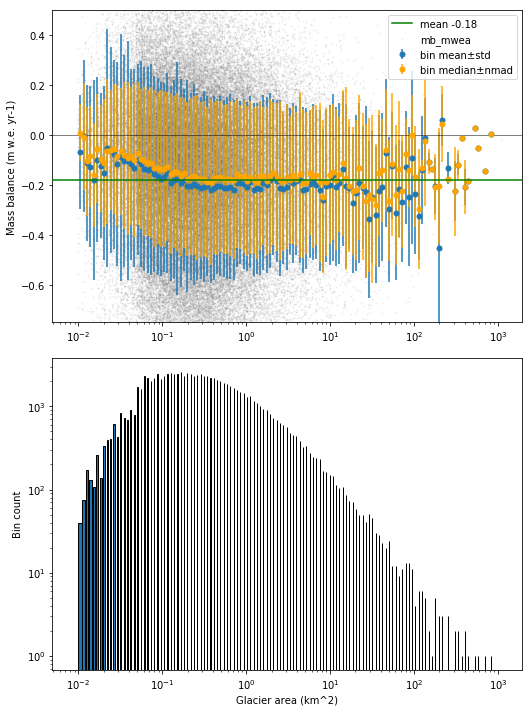

In [699]:
f,axa = plt.subplots(2, figsize=(7.5,10), sharex=True)
axa[0].scatter(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], s=1, c='0.5', alpha=0.1)
axa[0].errorbar(bin_centers, bin_mean, ls='none', yerr=bin_std, marker='o', markersize=5, label='bin mean\u00b1std')
axa[0].errorbar(bin_centers, bin_median, ls='none', c='orange', yerr=bin_nmad, marker='o', markersize=5, label='bin median\u00b1nmad')
axa[0].axhline(0,c='k',lw=0.5)
#axa[0].axhline(glac_df_mb_sort['mb_mwea'].median(),c='r')
axa[0].axhline(glac_df_mb_sort['mb_mwea'].mean(),c='g',zorder=999, label='mean %0.2f' % glac_df_mb_sort['mb_mwea'].mean())
axa[0].set_ylim(-0.75,0.5)
axa[1].bar(bin_centers, bin_count, width=bin_width, edgecolor='k')
#axa[1].bar(bin_centers, bin_count, edgecolor='k')
axa[1].set_xlabel('Glacier area (km^2)')
axa[0].set_xscale('log')
axa[0].set_ylabel('Mass balance (m w.e. yr-1)')
axa[1].set_yscale('log')
axa[1].set_ylabel('Bin count')
axa[0].legend()
#axa[1].set_ylim(0,10)
#axa[0].set_xlim(bins[0], bins[-1])
axa[0].xaxis.set_tick_params(which='both', labelbottom=True)
plt.tight_layout()
fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_area_v_mb.png'
f.savefig(fig_fn, dpi=300, bbox_inches='tight', pad_inches=0)

In [530]:
glac_df_mb_sort.columns

Index(['GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'O1Region',
       'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax',
       'Status', 'Connect', 'Form', 'TermType', 'Surging', 'Linkages', 'Name',
       'mascon', 'area_deg', 'area_km2', 'basin', 'elev_flag', 'lat_center',
       'lat_span', 'location', 'lon_center', 'lon_span', 'qdgc', 'lat', 'lon',
       'areakm2', 'id', 'left', 'top', 'right', 'bottom', 'kaab_region',
       'himap_region', 'basin_name', 'DN', 'ENDO', 'x', 'y', 'z_med', 'z_min',
       'z_max', 'z_slope', 'z_aspect', 'dhdt_ma', 'dhdt_ma_sigma', 'mb_mwea',
       'mb_mwea_sigma', 'area_m2', 'mb_m3wea', 'mb_m3wea_sigma', 't1', 't2',
       'dt', 'valid_area_perc', 'H_m', 'debris_m', 'perc_debris', 'perc_pond',
       'perc_clean', 'vm_ma', 'mb_Gta', 'mb_Gta_sigma', 'geometry', 'SNR'],
      dtype='object')

In [661]:
bins=np.logspace(-2,3,11)
bins

array([1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03])

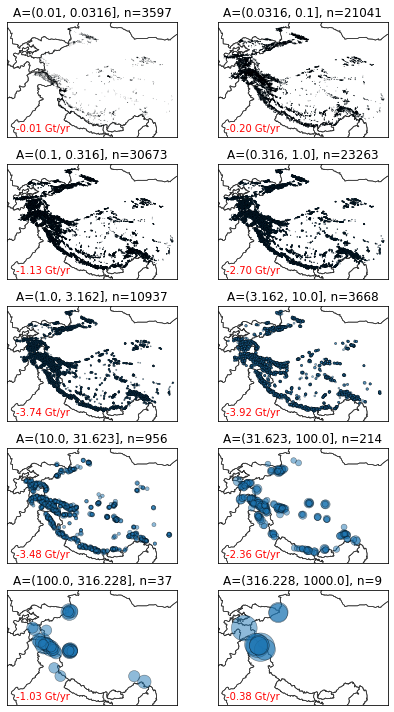

In [697]:
rc = (5,2)
df_cut = pd.cut(glac_df_mb_sort['Area'], bins)
f,axa = plt.subplots(*rc, figsize=(6,10), sharex=True, sharey=True)
axa = axa.ravel()

for n,i in enumerate(glac_df_mb_sort.groupby(df_cut)):
    border_df.plot(ax=axa[n], facecolor='none', edgecolor='0.2', lw=0.7)
    axa[n].scatter(i[1]['x'], i[1]['y'], s=i[1]['Area'], label=i[0], edgecolor='k', lw=0.5, alpha=0.5)
    axa[n].set_title('A=%s, n=%i' % (i[0], i[1].shape[0]))
    axa[n].annotate('%0.2f Gt/yr' % (i[1]['mb_m3wea'].sum()/1E9), xy=(0.05, 0.05), xycoords='axes fraction', color='r')
    pltlib.hide_ticks(axa[n])

axa[0].set_xlim(extent[0], extent[2])
axa[0].set_ylim(extent[1], extent[3])
axa[0].set_aspect('equal')

plt.tight_layout()
#plt.suptitle("Spatial distribution of glaciers, binned by area (km2)")
fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_area_spatial.png'
f.savefig(fig_fn, dpi=300, bbox_inches='tight', pad_inches=0)

In [666]:
glac_df_mb_sort['mb_m3wea'].groupby(df_cut).agg('sum')/1E9

Area
(0.01, 0.0316]      -0.01
(0.0316, 0.1]       -0.20
(0.1, 0.316]        -1.13
(0.316, 1.0]        -2.70
(1.0, 3.162]        -3.74
(3.162, 10.0]       -3.92
(10.0, 31.623]      -3.48
(31.623, 100.0]     -2.36
(100.0, 316.228]    -1.03
(316.228, 1000.0]   -0.38
Name: mb_m3wea, dtype: float64

In [653]:
#bins=np.arange(0,500,1)
bins=np.logspace(-2,3,128)
area = glac_df_mb_hex[('Area', 'sum')]
val = glac_df_mb_hex[('mb_mwea', 'Gta_to_mwea')]
#val = glac_df_mb_hex[('mb_mwea', 'mean')]
bin_count, bin_edges, binnumber = scipy.stats.binned_statistic(area, val, statistic='count', bins=bins)
bin_mean, bin_edges, binnumber = scipy.stats.binned_statistic(area, val, statistic='mean', bins=bins)
bin_std, bin_edges, binnumber = scipy.stats.binned_statistic(area, val, statistic=np.std, bins=bins)
bin_median, bin_edges, binnumber = scipy.stats.binned_statistic(area, val, statistic='median', bins=bins)
#scipy.stats.median_absolute_deviation in version 1.3.0
bin_nmad, bin_edges, binnumber = scipy.stats.binned_statistic(area, val, statistic=malib.mad, bins=bins)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

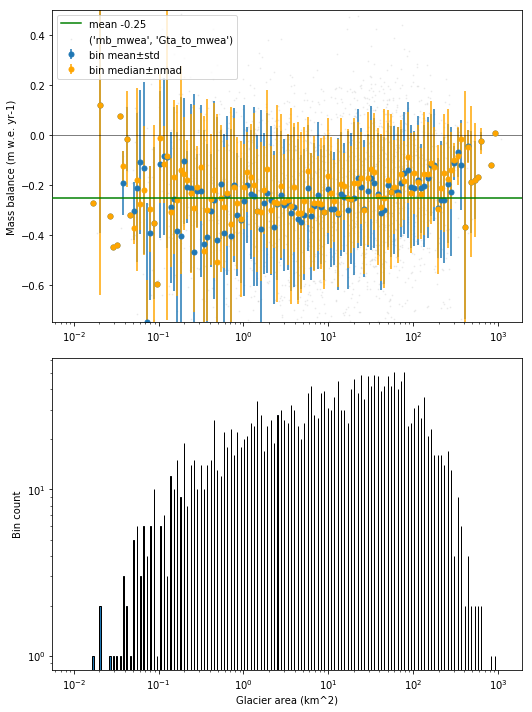

In [654]:
f,axa = plt.subplots(2, figsize=(7.5,10), sharex=True)
axa[0].scatter(area, val, s=1, c='0.5', alpha=0.1)
axa[0].errorbar(bin_centers, bin_mean, ls='none', yerr=bin_std, marker='o', markersize=5, label='bin mean\u00b1std')
axa[0].errorbar(bin_centers, bin_median, ls='none', c='orange', yerr=bin_nmad, marker='o', markersize=5, label='bin median\u00b1nmad')
axa[0].axhline(0,c='k',lw=0.5)
#axa[0].axhline(glac_df_mb_sort['mb_mwea'].median(),c='r')
axa[0].axhline(val.mean(),c='g',zorder=999, label='mean %0.2f' % val.mean())
axa[0].set_ylim(-0.75,0.5)
axa[1].bar(bin_centers, bin_count, width=bin_width, edgecolor='k')
axa[1].set_xlabel('Glacier area (km^2)')
axa[0].set_xscale('log')
axa[0].set_ylabel('Mass balance (m w.e. yr-1)')
axa[1].set_yscale('log')
axa[1].set_ylabel('Bin count')
axa[0].legend()
#axa[1].set_ylim(0,10)
#axa[0].set_xlim(bins[0], bins[-1])
axa[0].xaxis.set_tick_params(which='both', labelbottom=True)
plt.tight_layout()
#fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_area_v_mb.png'
#f.savefig(fig_fn, dpi=300, bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'Spatial distribution of glaciers, binned by area (km2)')

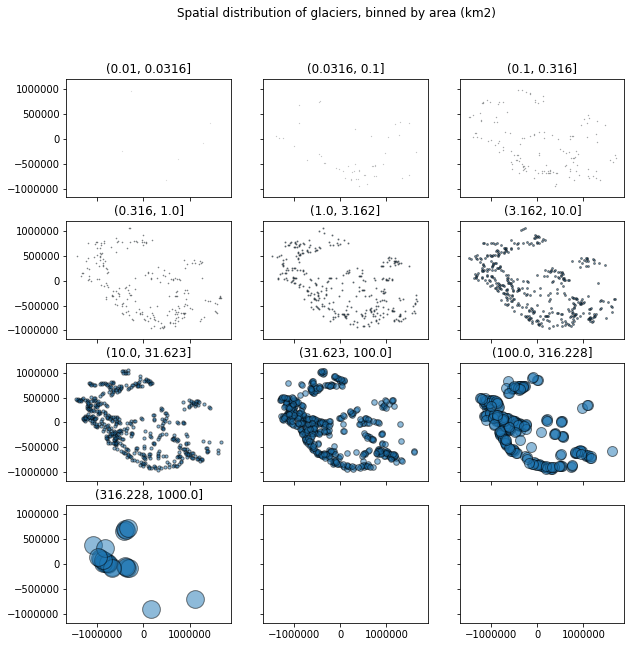

In [650]:
bins=np.logspace(-2,3,11)
df_cut = pd.cut(area, bins)
f,axa = plt.subplots(*rc, figsize=(10,10), sharex=True, sharey=True)
axa = axa.ravel()
for n,i in enumerate(glac_df_mb_hex.groupby(df_cut)):
    axa[n].scatter(i[1]['centroid_x'], i[1]['centroid_y'], s=i[0].left, label=i[0], edgecolor='k', alpha=0.5)
    axa[n].set_title(i[0])
ax.legend()
plt.suptitle("Spatial distribution of glaciers, binned by area (km2)")
#fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_area_spatial.png'
#f.savefig(fig_fn, dpi=300, bbox_inches='tight', pad_inches=0)

In [46]:
rgi_decyear=glac_df_mb_sort['BgnDate'].astype(int)/10000
miny = np.floor(rgi_decyear.min())
maxy = np.ceil(rgi_decyear.max())

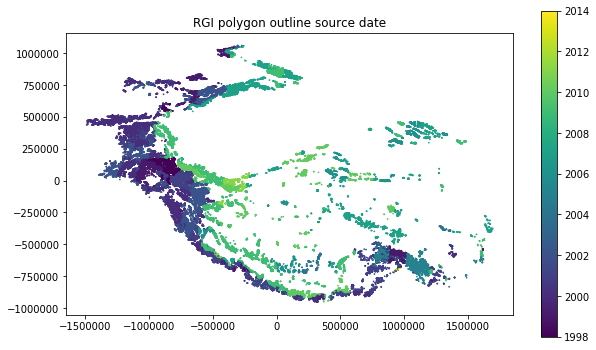

In [47]:
#RGI polygon date
f,ax = plt.subplots(figsize=(10,6))
sc = ax.scatter(glac_df_mb_sort['x'], glac_df_mb_sort['y'], c=rgi_decyear, s=0.5, vmin=miny, vmax=maxy)
plt.colorbar(sc)
ax.set_aspect('equal')
ax.set_title("RGI polygon outline source date")
#glac_df_mb_sort.plot.scatter(x='x', y='y', c='BgnDate')
rgi_date_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_RGI_sourceyear_fig.png'
f.savefig(rgi_date_fig_fn, **fig_opt)

In [48]:
# Check min/max mass numbers
rgi_idx = [glac_df_mb_sort['mb_m3wea'].idxmax(),]
rgi_idx.append(glac_df_mb_sort['mb_m3wea'].idxmin())
glac_df_mb_sort.loc[rgi_idx]

GLIMSId   BgnDate   EndDate  CenLon  CenLat O1Region  \
RGIId                                                                         
RGI60-14.04404  G075438E36192N  19980813  -9999999   75.44   36.19       14   
RGI60-15.11909  G096657E29334N  20050908  -9999999   96.66   29.33       15   

               O2Region   Area  Zmin  Zmax  Zmed  Slope  Aspect   Lmax  \
RGIId                                                                    
RGI60-14.04404        2 203.34  3314  7718  5391  23.60      21  31640   
RGI60-15.11909        3 179.59  3980  6341  5207  12.90      78  32403   

                Status  Connect  Form  TermType  Surging  Linkages  \
RGIId                                                                
RGI60-14.04404       0        0     0         0        3         9   
RGI60-15.11909       0        0     1         0        1         9   

                             Name  mascon  area_deg  area_km2    basin  \
RGIId                                                                    
RGI60-14.04404  Khurdopin Glacier  36N76E      1.00 12,373.54 5,051.00   
RGI60-15.11909            Yagnung  29N97E      1.00 12,406.28 5,035.00   

                elev_flag  lat_center  lat_span  location  lon_center  \
RGIId                                                                   
RGI60-14.04404       0.00       36.00      1.00     80.00       76.08   
RGI60-15.11909       0.00       29.00      1.00     80.00       96.88   

                lon_span      qdgc    lat    lon     areakm2     id  \
RGIId                                                                 
RGI60-14.04404      1.24  E075N36C  36.25  75.25  2493.27629   2985   
RGI60-15.11909      1.15  E096N29D  29.25  96.75  2693.48103  11025   

                       left         top        right      bottom  \
RGIId                                                              
RGI60-14.04404  -842,814.95   71,740.08  -813,947.44   46,740.08   
RGI60-15.11909 1,105,742.21 -678,259.92 1,134,609.72 -703,259.92   

                   kaab_region     himap_region   basin_name    DN  ENDO  \
RGIId                                                                      
RGI60-14.04404       Karakoram        Karakoram        Indus  5367     0   
RGI60-15.11909  Nyainqentangla  Nyainqentanglha  Brahmaputra    21     0   

                          x           y    z_med    z_min    z_max  z_slope  \
RGIId                                                                         
RGI60-14.04404  -838,312.43   62,425.23 5,369.00 3,295.32 7,510.49    15.66   
RGI60-15.11909 1,117,064.38 -685,115.41 5,166.14 3,921.18 6,317.99     9.99   

                z_aspect  dhdt_ma  dhdt_ma_sigma  mb_mwea  mb_mwea_sigma  \
RGIId                                                                      
RGI60-14.04404    143.91     0.23           0.01     0.20           0.06   
RGI60-15.11909    116.07    -1.30           0.01    -1.10           0.09   

                      area_m2        mb_m3wea  mb_m3wea_sigma       t1  \
RGIId                                                                    
RGI60-14.04404 203,335,845.65   39,691,132.12    5,224,127.20 2,000.41   
RGI60-15.11909 179,589,230.18 -198,383,836.77   24,336,811.74 2,000.41   

                     t2    dt  valid_area_perc    H_m  debris_m  perc_debris  \
RGIId                                                                          
RGI60-14.04404 2,018.41 18.00           100.00 142.66      0.18        15.82   
RGI60-15.11909 2,018.41 18.00            99.96 171.93      0.14        10.37   

                perc_pond  perc_clean  vm_ma  mb_Gta  mb_Gta_sigma  \
RGIId                                                                
RGI60-14.04404       0.45       83.72  53.99    0.04          0.01   
RGI60-15.11909       0.13       89.51  61.99   -0.20          0.02   

                                                         geometry  
RGIId                                                              
RGI60-14.04404  PO

In [28]:
#mb_m3wea_sigma_thresh = glac_df_mb_sort['mb_m3wea_sigma'].quantile(0.99)
#glac_df_mb_sort = glac_df_mb_sort[glac_df_mb_sort['mb_m3wea_sigma'] < mb_m3wea_sigma_thresh]

In [49]:
#Evaluate SNR
glac_df_mb_sort['SNR'] = glac_df_mb_sort['mb_m3wea'].abs()/glac_df_mb_sort['mb_m3wea_sigma']

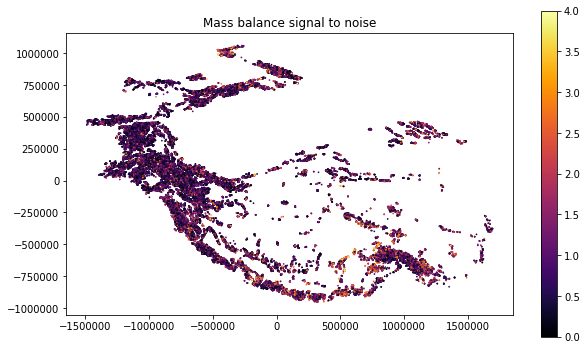

In [50]:
f,ax = plt.subplots(figsize=(10,6))
sc = ax.scatter(glac_df_mb_sort['x'], glac_df_mb_sort['y'], c=glac_df_mb_sort['SNR'], s=0.5, cmap='inferno', vmin=0, vmax=4)
plt.colorbar(sc)
ax.set_aspect('equal')
ax.set_title("Mass balance signal to noise")
#glac_df_mb_sort.plot.scatter(x='x', y='y', c='BgnDate')
rgi_date_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_SNR_fig.png'
f.savefig(rgi_date_fig_fn, **fig_opt)

(-10000000.0, 10000000.0)

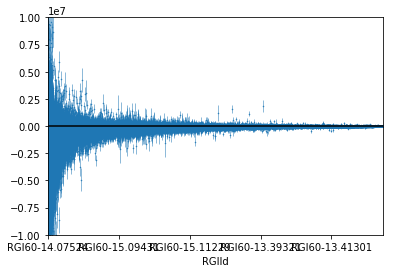

In [51]:
#Plot mb and error for all glaciers, sorted by area
f, ax = plt.subplots()
glac_df_mb_sort['mb_m3wea'].plot(marker='.', markersize=1, ls='none', lw=0.5, \
                                 yerr=glac_df_mb_sort['mb_m3wea_sigma'], ax=ax)
ax.axhline(0, color='k', zorder=99)
ax.set_ylim(-0.1E8, 0.1E8)

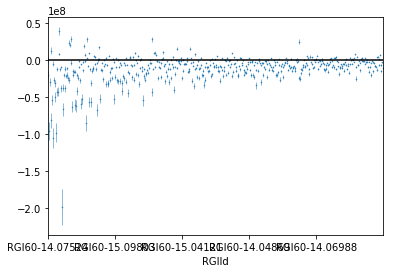

In [52]:
f, ax = plt.subplots()
cutoff = 500
glac_df_mb_sort['mb_m3wea'].head(cutoff).plot(marker='.', markersize=1, ls='none', lw=0.5, \
                                 yerr=glac_df_mb_sort['mb_m3wea_sigma'].head(cutoff), ax=ax)
ax.axhline(0, color='k', zorder=99)

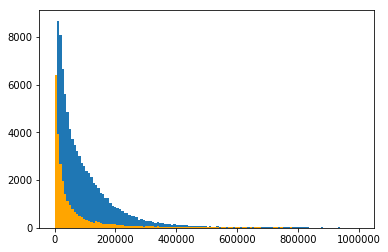

In [53]:
f, ax = plt.subplots()
asdf = ax.hist(glac_df_mb_sort['mb_m3wea_sigma'], bins=128, range=(0,1E6))
asdf = ax.hist(glac_df_mb_sort['mb_m3wea'], bins=128, range=(0,1E6), color='orange')
#mb_df['mb_m3wea'].hist(bins=128, range=(0,1E6),ax=ax)

In [54]:
idx = slice(0,100000)
print(glac_df_mb_sort['mb_m3wea'].iloc[idx].sum()/1E9)
print(rss(glac_df_mb_sort['mb_m3wea_sigma'].iloc[idx])/1E9)
print(glac_df_mb_sort['mb_m3wea_sigma'][idx].sum()/1E9)

-18.975358849018
0.08059568665708697
10.541023129204001


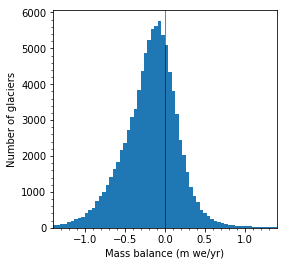

In [55]:
f, ax = plt.subplots(figsize=(4,4))
ax.set_xlabel('Mass balance (m we/yr)')
ax.set_ylabel('Number of glaciers')
hist_clim = (-1.4, 1.4)
ax.set_xlim(*hist_clim)
glac_df_mb['mb_mwea'].hist(range=hist_clim, bins=64, grid=False)
ax.axvline(0, lw=0.5, color='k')
ax.minorticks_on()

In [56]:
if outlier_removal:
    print("Removing outliers")

    #outlier_perc = (0.01, 0.99)
    outlier_perc = (0.001, 0.999)
    #outlier_clim = (glac_df_mb['mb_mwea'].quantile(outlier_perc[0]), glac_df_mb['mb_mwea'].quantile(outlier_perc[1]))
    std_f = 3.5
    #outlier_clim = glac_df_mb['mb_mwea'].mean() - std_f*glac_df_mb['mb_mwea'].std()
    outlier_clim = glac_df_mb['mb_mwea'].median() - std_f*malib.mad(glac_df_mb['mb_mwea'].values)
    outlier_clim = (outlier_clim, -outlier_clim)
    print("Removing outliers (%0.2f, %0.2f)" % (outlier_clim))
    #inlier_idx = np.abs(glac_df_mb['mb_mwea'] - glac_df_mb['mb_mwea'].mean()) <= (3*glac_df_mb['mb_mwea'].std())
    inlier_idx = (glac_df_mb['mb_mwea'] >= outlier_clim[0]) & (glac_df_mb['mb_mwea'] <= outlier_clim[1])

    print("%i records before outlier removal" % (glac_df_mb.shape[0]))
    glac_df_mb = glac_df_mb[inlier_idx]
    print("%i records after outlier removal" % (glac_df_mb.shape[0]))

    if False:
        glac_df_mb['mb_mwea'].hist(range=hist_clim, bins=256, label='After outlier filter')
        ax.axvline(0, linewidth=0.5, color='k')
        ax.legend()

In [57]:
test = aggregate(glac_df, glac_df_mb, 'Status')

In [58]:
test.T

Status                                           0
area_m2        mean                   1,027,179.23
               sum               97,002,698,226.23
mb_mwea        mean                          -0.18
               median                        -0.15
               std                            0.38
               sum                      -17,169.20
               size                      94,436.00
mb_mwea_sigma  mean                           0.26
               sum                       24,907.88
               rss                           98.42
mb_m3wea       mean                    -200,933.53
               median                   -25,197.92
               sum              -18,975,358,849.02
mb_m3wea_sigma mean                     111,620.81
               sum               10,541,023,129.20
               rss                   80,595,686.66
               rms                      262,266.61
mb_Gta         sum                          -18.98
mb_Gta_sigma   mean                           0.00
               sum                           10.54
               rss                            0.08
               rms                            0.00
Area           mean                           1.03
               sum                       97,002.78
t1             mean                       2,000.41
               amin                       2,000.41
               amax                       2,000.41
t2             mean                       2,018.41
               amin                       2,018.41
               amax                       2,018.41
dt             mean                          18.00
               amin                          18.00
               amax                          18.00
mb_Gta         rss                            0.08
mb_mwea        count                     94,436.00
Area_all       mean                           1.03
               sum                       97,300.12
Area           perc                          99.69
mb_mwea        total_m3a        -17,689,916,404.47
               total_Gta                    -17.69
mb_mwe_cum     mean                          -3.27
               total_m3        -318,418,495,280.53
               total_Gt                    -318.42
meltwater      count                     66,567.00
               total_m3a        -22,735,706,832.68
               total_m3a_sigma    8,004,906,303.57
               total_Gta                    -22.74
               total_Gta_sigma                8.00
               total_mmSLEa                  -0.06
meltwater_cum  total_m3        -409,242,722,988.28
               total_Gt                    -409.24
               total_mmSLE                 -409.24

In [59]:
glac_df_mb.describe()

CenLon    CenLat      Area      Zmin      Zmax      Zmed     Slope  \
count 94,436.00 94,436.00 94,436.00 94,436.00 94,436.00 94,436.00 94,436.00   
mean      81.11     35.52      1.03  4,856.40  5,307.79  5,082.02     25.91   
std        7.98      4.38      7.75    694.80    704.81    681.92      7.77   
min       67.48     27.49      0.01    521.00  1,141.00    610.00     -9.00   
25%       75.07     31.81      0.10  4,347.00  4,828.00  4,605.00     20.20   
50%       78.71     35.84      0.23  4,950.00  5,426.00  5,194.00     25.30   
75%       86.28     38.44      0.63  5,396.00  5,847.00  5,620.00     31.00   
max      103.15     45.35  1,077.96  7,624.00  8,799.00  7,828.00     69.50   

         Aspect      Lmax    Status   Connect      Form  TermType   Surging  \
count 94,436.00 94,436.00 94,436.00 94,436.00 94,436.00 94,436.00 94,436.00   
mean     171.64  1,220.09      0.00      0.00      0.02      0.00      7.20   
std      130.38  1,752.04      0.00      0.00      0.15      0.00      3.59   
min       -9.00     -9.00      0.00      0.00      0.00      0.00      0.00   
25%       40.00    432.00      0.00      0.00      0.00      0.00      9.00   
50%      156.00    728.00      0.00      0.00      0.00      0.00      9.00   
75%      311.00  1,355.00      0.00      0.00      0.00      0.00      9.00   
max      360.00 76,460.00      0.00      0.00      1.00      0.00      9.00   

       Linkages  area_deg  area_km2     basin  elev_flag  lat_center  \
count 94,436.00 94,436.00 94,436.00 94,436.00  94,436.00   94,436.00   
mean       8.93      1.00 12,391.12  5,245.26       0.00       35.52   
std        0.78      0.00     11.77    410.09       0.00        4.39   
min        0.00      1.00 12,373.54  5,004.00       0.00       27.00   
25%        9.00      1.00 12,380.52  5,007.00       0.00       32.00   
50%        9.00      1.00 12,392.33  5,035.00       0.00       36.00   
75%        9.00      1.00 12,401.62  5,051.00       0.00       38.00   
max        9.00      1.00 12,413.85  6,019.00       0.00       45.00   

       lat_span  location  lon_center  lon_span        id          left  \
count 94,436.00 94,436.00   94,436.00 94,436.00 94,436.00     94,436.00   
mean       1.00     80.00       81.11      1.24  5,042.48   -343,123.54   
std        0.00      0.00        7.99      0.07  2,931.72    711,088.43   
min        1.00     80.00       67.74      1.12    298.00 -1,492,334.00   
25%        1.00     80.00       74.85      1.18  2,811.00   -886,116.22   
50%        1.00     80.00       78.88      1.24  4,116.00   -561,356.69   
75%        1.00     80.00       85.98      1.27  6,871.00    109,812.99   
max        1.00     80.00      103.44      1.42 13,416.00  1,690,309.36   

               top         right       bottom        DN      ENDO  \
count    94,436.00     94,436.00    94,436.00 94,436.00 94,436.00   
mean     -6,430.58   -314,256.02   -31,430.58  4,299.33      0.52   
std     498,575.49    711,088.43   498,575.49  5,186.84      0.50   
min    -940,759.92 -1,463,466.49  -965,759.92     11.00      0.00   
25%    -428,259.92   -857,248.71  -453,259.92  1,270.00      0.00   
50%      34,240.08   -532,489.18     9,240.08  3,546.00      1.00   
75%     359,240.08    138,680.51   334,240.08  5,367.00      1.00   
max   1,071,740.08  1,719,176.87 1,046,740.08 26,369.00      1.00   

                  x            y     z_med     z_min     z_max   z_slope  \
count     94,436.00    94,436.00 94,436.00 94,436.00 94,436.00 94,436.00   
mean    -328,729.82   -18,918.09  5,055.50  4,830.32  5,292.32     26.87   
std      711,130.99   498,497.10    685.86    697.42    708.75      8.73   
min   -1,488,027.43  -950,447.98  2,866.82  2,289.59  3,050.73      2.03   
25%     -864,263.20  -438,552.40  4,585.75  4,328.88  4,816.29     20.18   
50%     -557,373.75    21,709.09  5,163.87  4,924.08  5,406.90     26.48   
75%      116,283.35   344,098.36  5,596.18  5,368.18  5,835.34     33.08   
max    1,694,017.64 1,058,598.

# Sampling for 25-km hexagon bins

In [333]:
if hex_shp_fn is not None:
    glac_df_mb_hex = spatial_aggregate(glac_df, glac_df_mb, hex_df, hex_col)

In [334]:
#glac_gdf_mb_hex = gpd.GeoDataFrame(glac_df_mb_hex, geometry=hex_df.geometry)
from shapely.geometry import Point
hex_geom = [Point(p) for p in zip(glac_df_mb_hex['centroid_x'], glac_df_mb_hex['centroid_y'])]
glac_gdf_mb_hex = gpd.GeoDataFrame(glac_df_mb_hex, geometry=hex_geom)

In [335]:
#Note, some nan values for some columns here
glac_df_mb_hex.head()

(area_m2, mean)   (area_m2, sum)  (mb_mwea, mean)  (mb_mwea, median)  \
id                                                                           
3434    72,021,266.76 1,080,319,001.34            -0.07              -0.09   
3255    12,300,046.32   910,203,428.02             0.03               0.02   
1904    26,353,797.16   764,260,117.65            -0.03              -0.04   
2986    18,000,865.03   630,030,276.20            -0.08              -0.07   
2897     9,305,746.59   614,179,274.66            -0.08              -0.06   

      (mb_mwea, std)  (mb_mwea, sum)  (mb_mwea, size)  (mb_mwea_sigma, mean)  \
id                                                                             
3434            0.14           -1.08            15.00                   0.21   
3255            0.34            2.08            74.00                   0.33   
1904            0.17           -0.84            29.00                   0.24   
2986            0.47           -2.67            35.00                   0.37   
2897            0.22           -5.28            66.00                   0.29   

      (mb_mwea_sigma, sum)  (mb_mwea_sigma, rss)  (mb_m3wea, mean)  \
id                                                                   
3434                  3.11                  0.89     -1,321,198.82   
3255                 24.43                  3.40         87,838.03   
1904                  6.85                  1.47     -3,204,054.59   
2986                 12.89                  2.57     -1,056,121.04   
2897                 19.10                  2.69        114,579.89   

      (mb_m3wea, median)  (mb_m3wea, sum)  (mb_m3wea_sigma, mean)  \
id                                                                  
3434           -3,871.67   -19,817,982.27              384,108.26   
3255            3,180.16     6,500,014.03              162,636.54   
1904          -12,294.99   -92,917,583.03              532,240.62   
2986          -14,682.09   -36,964,236.45              243,235.52   
2897          -10,427.57     7,562,273.00              172,280.94   

      (mb_m3wea_sigma, sum)  (mb_m3wea_sigma, rss)  (mb_m3wea_sigma, rms)  \
id                                                                          
3434           5,761,623.90           5,369,394.75           1,386,371.76   
3255          12,035,103.68           4,576,280.15             531,981.76   
1904          15,434,978.11          12,179,049.64           2,261,592.74   
2986           8,513,243.14           4,998,436.84             844,890.03   
2897          11,370,541.87           4,724,259.72             581,516.17   

      (mb_Gta, sum)  (mb_Gta_sigma, mean)  (mb_Gta_sigma, sum)  \
id                                                               
3434          -0.02                  0.00                 0.01   
3255           0.01                  0.00                 0.01   
1904          -0.09                  0.00                 0.02   
2986          -0.04                  0.00                 0.01   
2897           0.01                  0.00                 0.01   

      (mb_Gta_sigma, rss)  (mb_Gta_sigma, rms)  (Area, mean)  (Area, sum)  \
id                                                                          
3434                 0.01                 0.00         72.02     1,080.32   
3255                 0.00                 0.00         12.30       910.21   
1904                 0.01                 0.00         26.35       764.26   
2986                 0.00                 0.00         18.00       630.03   
2897                 0.00                 0.00          9.31       614.18   

      (t1, mean)  (t1, amin)  (t1, amax)  (t2, mean)  (t2, amin)  (t2, amax)  \
id                                                                             
3434    2,000.41    2,000.41    2,000.41    2,018.41    2,018.41    2,018.41   
3255    2,000.41    2,000.41    2,000.41    2,018.41    2,018.41    2,018.41   
1904    2,000.41    2,000.41    2,000.41    2,018.41    2,01

In [286]:
#hma_stats = glac_df_mb_hex.mean(axis=0)
#hma_stats

## HMA-wide numbers

In [251]:
glac_df_mb_hex

(area_m2, mean)   (area_m2, sum)  (mb_mwea, mean)  (mb_mwea, median)  \
id                                                                            
3434     72,021,266.76 1,080,319,001.34            -0.07              -0.09   
3255     12,300,046.32   910,203,428.02             0.03               0.02   
1904     26,353,797.16   764,260,117.65            -0.03              -0.04   
2986     18,000,865.03   630,030,276.20            -0.08              -0.07   
2897      9,305,746.59   614,179,274.66            -0.08              -0.06   
4948     26,347,594.67   579,647,082.84             0.02              -0.00   
3613     16,246,579.99   568,630,299.63            -0.03              -0.04   
4652      7,463,289.62   514,966,983.64             0.08               0.03   
4739     22,574,389.30   496,636,564.51            -0.27              -0.21   
2627     10,416,527.06   458,327,190.80             0.07               0.02   
4829      9,573,353.52   449,947,615.42            -0.32              -0.29   
2985      7,246,594.40   434,795,663.77             0.02              -0.00   
3164      9,084,938.49   426,992,109.03            -0.02               0.01   
3076      6,395,850.48   415,730,281.17             0.21               0.16   
2808      5,737,766.24   413,119,169.59             0.13               0.11   
11025    10,323,644.09   371,651,187.20            -0.33              -0.49   
5006      6,370,823.09   369,507,739.09             0.08               0.10   
2538      4,286,055.95   360,028,699.49             0.17               0.11   
4769      5,552,163.24   349,786,284.41             0.08               0.08   
3254      6,590,094.66   349,275,017.14             0.03               0.02   
5126      9,179,782.40   339,651,948.96            -0.10              -0.10   
4859      6,061,072.41   339,420,055.08             0.05               0.06   
7117      2,789,379.95   337,514,973.71            -0.30              -0.28   
3614      7,610,914.67   334,880,245.41             0.06               0.08   
2806      4,772,895.96   329,329,821.13             0.07               0.09   
2974      7,809,892.85   328,015,499.56             0.13               0.12   
2359      2,964,004.79   323,076,521.60             0.01               0.02   
4860     10,893,241.00   315,903,989.00            -0.07              -0.04   
3611      2,686,836.20   311,672,999.66             0.06               0.08   
3794      4,318,451.61   310,928,516.05            -0.06              -0.04   
...                ...              ...              ...                ...   
2694         66,032.00        66,032.00             0.53               0.53   
7382         65,956.59        65,956.59            -0.56              -0.56   
9603         62,892.63        62,892.63            -0.14              -0.14   
3450         59,551.79        59,551.79            -0.35              -0.35   
1296         60,161.06        60,161.06             0.30               0.30   
6037         57,134.13        57,134.13            -0.28              -0.28   
2708         55,158.38        55,158.38             0.09               0.09   
8624         54,884.19        54,884.19            -0.72              -0.72   
8809         54,367.69        54,367.69            -0.33              -0.33   
9239         52,467.40        52,467.40            -0.03              -0.03   
7103         25,876.64        51,753.27             0.12               0.12   
11253        51,701.90        51,701.90            -0.40              -0.40   
9329         50,663.53        50,663.53            -0.37              -0.37   
11919        49,701.71        49,701.71            -0.41              -0.41   
671          49,690.82        49,690.82            -0.14              -0.14   
7725         49,148.86        49,148.86            -0.19              -0.19   
7381         23,579.05        47,158.10            -0.42              -0.42   
11696        21,908.02        43,816.05            -0.31 

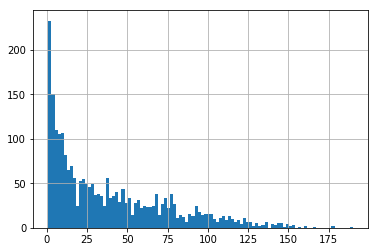

In [367]:
glac_df_mb_hex[('mb_mwea', 'size')].hist(bins=100)

In [370]:
print(glac_df_mb_hex[('mb_mwea', 'size')].mean())
print(glac_df_mb_hex[('mb_mwea', 'size')].min())
print(glac_df_mb_hex[('mb_mwea', 'size')].max())

38.990916597853015
1.0
190.0


In [327]:
#Sum of all hex samples - full region mb and uncertainty
hma_stats = glac_df_mb_hex.sum(axis=0)
hma_stats

(area_m2, mean)                      2,067,646,001.18
(area_m2, sum)                      97,002,698,226.23
(mb_mwea, mean)                               -517.52
(mb_mwea, median)                             -528.25
(mb_mwea, std)                                 574.64
(mb_mwea, sum)                             -17,169.20
(mb_mwea, size)                             94,436.00
(mb_mwea_sigma, mean)                          669.06
(mb_mwea_sigma, sum)                        24,907.88
(mb_mwea_sigma, rss)                         3,898.69
(mb_m3wea, mean)                      -405,651,000.61
(mb_m3wea, median)                    -120,655,014.78
(mb_m3wea, sum)                    -18,975,358,849.02
(mb_m3wea_sigma, mean)                 237,474,249.82
(mb_m3wea_sigma, sum)               10,541,023,129.20
(mb_m3wea_sigma, rss)                2,245,683,808.93
(mb_m3wea_sigma, rms)                  355,457,885.56
(mb_Gta, sum)                                  -18.98
(mb_Gta_sigma, mean)        

In [290]:
print('%0.2f\u00b1%0.2f Gt/yr' % (hma_stats[('mb_Gta', 'sum')], hma_stats[('mb_Gta_sigma', 'rss')]))
print('%0.1f\u00b1%0.1f Gt/yr' % (hma_stats[('mb_Gta', 'sum')], hma_stats[('mb_Gta_sigma', 'rss')]))

-18.98±2.25 Gt/yr
-19.0±2.2 Gt/yr


In [357]:
print('%0.3f\u00b1%0.3f mmSLE/yr' % (hma_stats[('mb_Gta', 'sum')]/Gt2mm, hma_stats[('mb_Gta_sigma', 'rss')]/Gt2mm))

-0.052±0.006 mmSLE/yr


In [358]:
dt = 18.0
print('%0.3f\u00b1%0.3f mmSLE' % (dt*hma_stats[('mb_Gta', 'sum')]/Gt2mm, dt*hma_stats[('mb_Gta_sigma', 'rss')]/Gt2mm))

-0.942±0.112 mmSLE


In [294]:
print('%0.2f\u00b1%0.2f Gt' % (dt*hma_stats[('mb_Gta', 'sum')], dt*hma_stats[('mb_Gta_sigma', 'rss')]))

-341.56±40.42 Gt


In [216]:
hma_stats_m = 1000*hma_stats/hma_stats[('Area', 'sum')]
print('%0.2f\u00b1%0.2f m we/yr' % (hma_stats_m[('mb_Gta', 'sum')], hma_stats_m[('mb_Gta_sigma', 'rss')]))
print('%0.1f\u00b1%0.1f m we/yr' % (hma_stats_m[('mb_Gta', 'sum')], hma_stats_m[('mb_Gta_sigma', 'rss')]))

-0.20±0.02 m we/yr
-0.2±0.0 m we/yr


In [179]:
title = suptitle + ": 25-km Hex Grid Cells"

In [180]:
scaling_f = 0.2

Plotting borders
Plotting scatterplot of ('mb_Gta', 'sum') values
Plotting borders
Plotting scatterplot of ('mb_Gta_sigma', 'sum') values


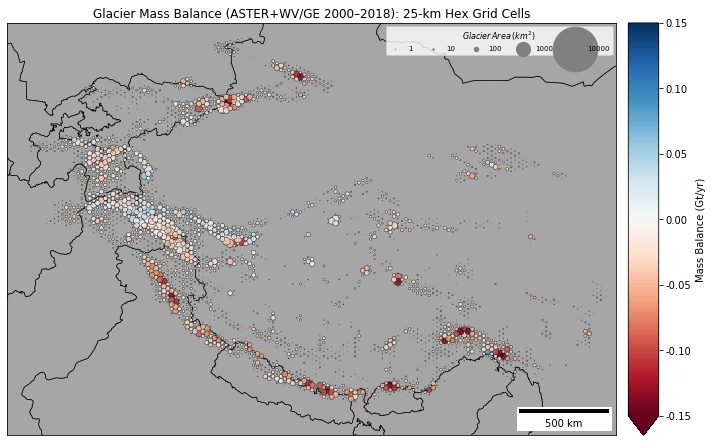

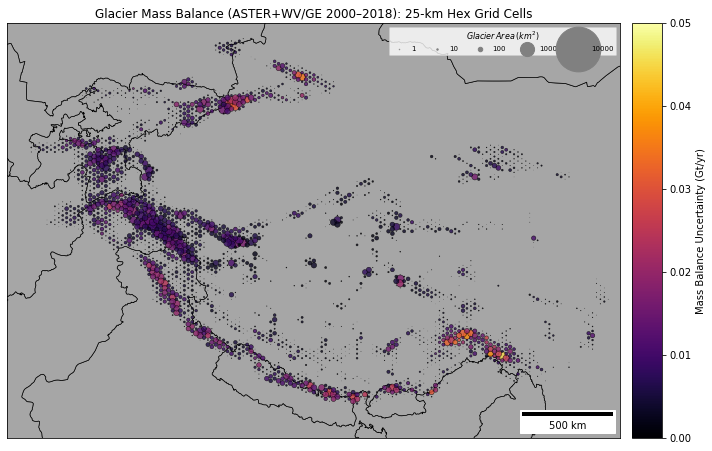

In [181]:
out_fn_suffix = '_hex_mb_Gta'
mb_gt_clim = (-0.15,0.15)
hex_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_gt_clim, crs=crs, extent=extent, labels=None, title=title)
hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
hex_fig.savefig(hex_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0)
mb_gt_sigma_clim = (0.00,0.05)
hex_sigma_fig = make_map(col=('mb_Gta_sigma', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_gt_sigma_clim, crs=crs, extent=extent, labels=None, title=title)
hex_sigma_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_sigma.png'
hex_sigma_fig.savefig(hex_sigma_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0)

Plotting borders
Plotting scatterplot of ('mb_mwea', 'mean') values
Plotting borders
Plotting scatterplot of ('mb_mwea_sigma', 'mean') values


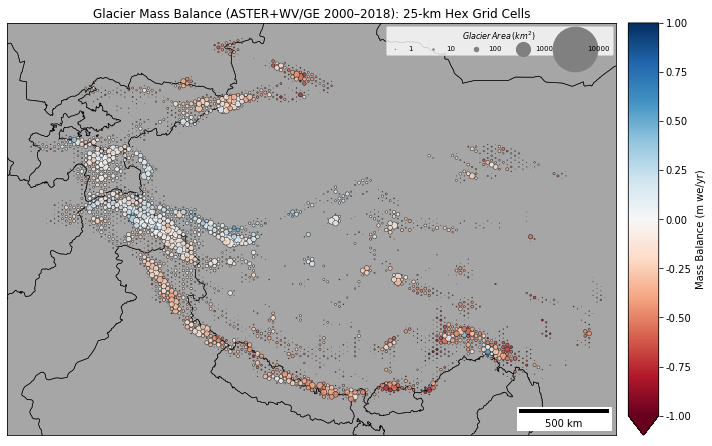

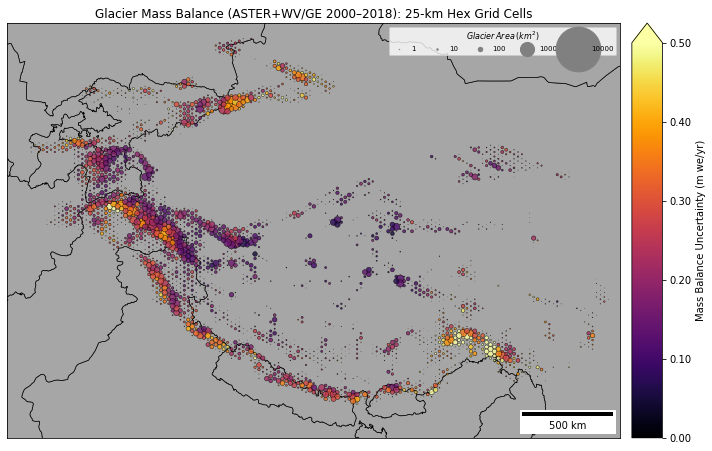

In [182]:
out_fn_suffix = '_hex_mb_mwea'
mb_mwea_clim = (-1.0,1.0)
hex_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_clim, crs=crs, extent=extent, labels=None, title=title)
hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
hex_fig.savefig(hex_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0)
mb_mwea_sigma_clim = (0,0.5)
hex_sigma_fig = make_map(col=('mb_mwea_sigma', 'mean'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_sigma_clim, crs=crs, extent=extent, labels=None, title=title)
hex_sigma_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_sigma.png'
hex_sigma_fig.savefig(hex_sigma_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0)

Plotting borders
Plotting scatterplot of ('mb_mwea', 'Gta_to_mwea') values
Plotting borders
Plotting scatterplot of ('mb_mwea_sigma', 'Gta_to_mwea') values


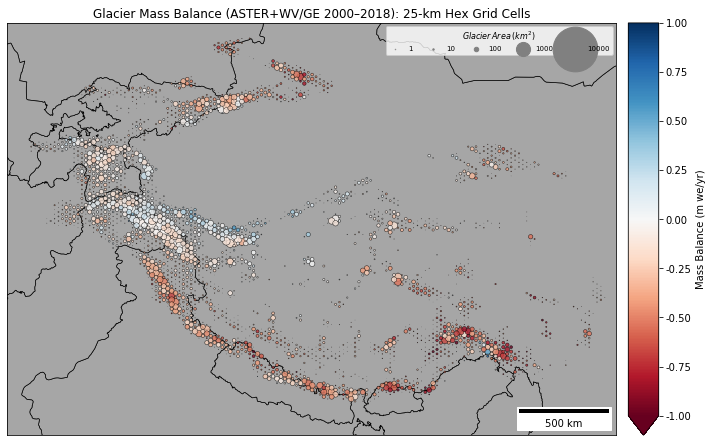

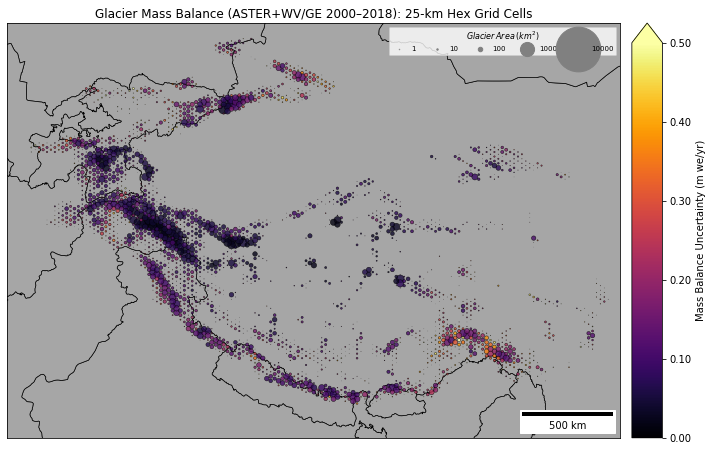

In [183]:
out_fn_suffix = '_hex_mb_Gta_to_mwea'
mb_mwea_clim = (-1.0,1.0)
hex_fig = make_map(col=('mb_mwea', 'Gta_to_mwea'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_clim, crs=crs, extent=extent, labels=None, title=title)
hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
hex_fig.savefig(hex_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0)
mb_mwea_sigma_clim = (0,0.5)
hex_sigma_fig = make_map(col=('mb_mwea_sigma', 'Gta_to_mwea'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_sigma_clim, crs=crs, extent=extent, labels=None, title=title)
hex_sigma_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_sigma.png'
hex_sigma_fig.savefig(hex_sigma_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0)

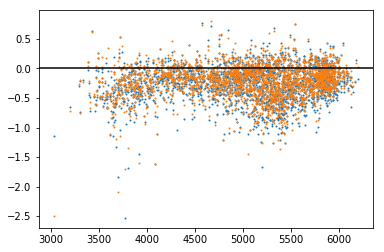

In [840]:
f,ax = plt.subplots()
z=glac_df_mb_hex[('z_med', 'median')]
mb=glac_df_mb_hex[('mb_mwea', 'Gta_to_mwea')]
mb2=glac_df_mb_hex[('mb_mwea', 'mean')]
#mb=glac_df_mb_hex[('mb_Gta', 'sum')]

ax.scatter(z,mb,s=1)
ax.scatter(z,mb2,s=1)
ax.axhline(0,c='k')
#ax.set_ylim(-0.1, 0.05)

In [845]:
import statsmodels.api as sm

In [846]:
sm.add_constantOLS?

In [780]:
def norm(a, percentile=(0.5, 99.5)):
    #amin, amax = (a.min(), a.max())
    amin, amax = np.nanpercentile(a, percentile)
    print(amin, amax)
    return ((a - amin)/(amax - amin))

-1.1475526289366629 0.47651632140634054
3425.31845 6092.043895


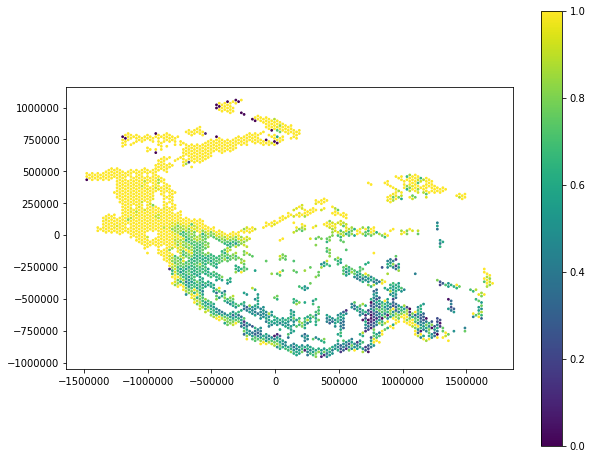

In [832]:
f,ax = plt.subplots(figsize=(10,8))
x=glac_df_mb_hex['centroid_x'].values
y=glac_df_mb_hex['centroid_y'].values
z=glac_df_mb_hex[('z_med', 'median')]
mb=glac_df_mb_hex[('mb_mwea', 'Gta_to_mwea')]
#mb=glac_df_mb_hex[('mb_mwea', 'mean')]
#asdf = norm(mb/z)
asdf = norm(mb)/norm(z)
clim=(0,1)
sc = ax.scatter(x,y,c=asdf,s=3,vmin=clim[0],vmax=clim[1])
plt.colorbar(sc)
ax.set_aspect('equal')

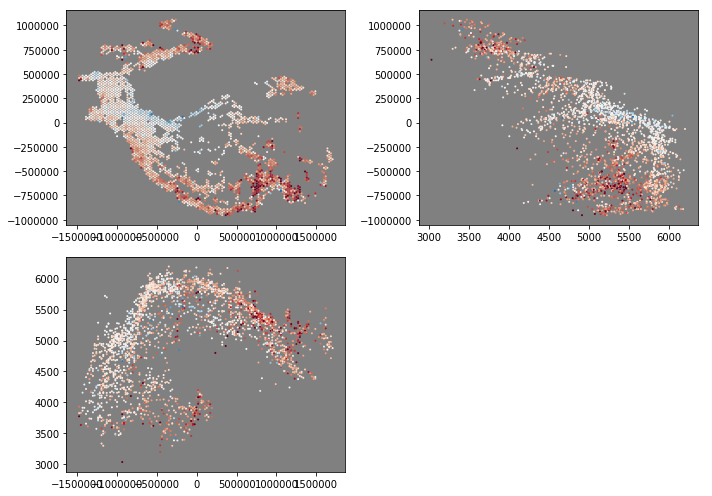

In [833]:
f,axa = plt.subplots(2,2,figsize=(10,7))
clim = (-1,1)
#axa[0][0].set_aspect('equal')
axa[0][0].scatter(x,y,c=mb,s=1,vmin=clim[0],vmax=clim[1],cmap='RdBu')
axa[1][0].scatter(x,z,c=mb,s=1,vmin=clim[0],vmax=clim[1],cmap='RdBu')
axa[0][1].scatter(z,y,c=mb,s=1,vmin=clim[0],vmax=clim[1],cmap='RdBu')
axa[1][1].axis('off')
plt.tight_layout()
for ax in axa.ravel():
    ax.set_facecolor('0.5')

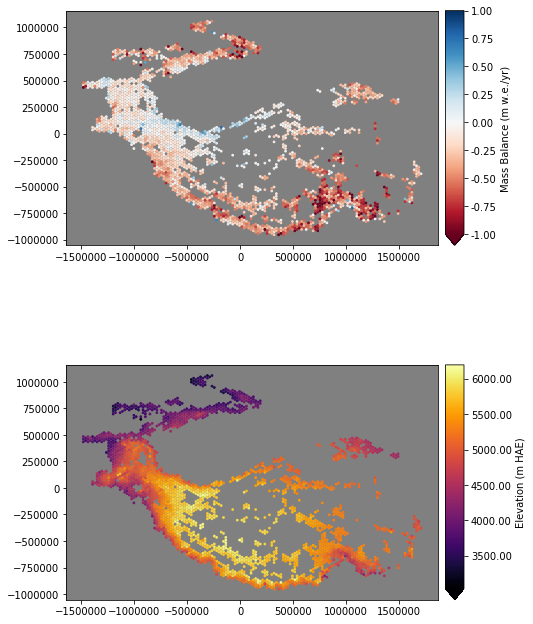

In [838]:
f,axa = plt.subplots(2, figsize=(7.5,10))
clim = (-1,1)
#axa[0][0].set_aspect('equal')
mb_m = axa[0].scatter(x,y,c=mb,s=3,vmin=clim[0],vmax=clim[1],cmap='RdBu')
z_m = axa[1].scatter(x,y,c=z,s=3,cmap='inferno')
pltlib.add_cbar(axa[0], mb_m, label='Mass Balance (m w.e./yr)')
pltlib.add_cbar(axa[1], z_m, label='Elevation (m HAE)')

for ax in axa.ravel():
    ax.set_aspect('equal')
    ax.set_facecolor('0.5')
plt.tight_layout()

## Regional aggregation

In [303]:
def hex_agg(glac_gdf_mb_hex, region_df, region_col):
    print("One-time spatial join by hex")
    glac_gdf_mb_hex_region = gpd.sjoin(glac_gdf_mb_hex, region_df, how="inner", op="within")
    glac_gdf_mb_hex_region.rename(index=str, columns={'index_right':region_col}, inplace=True)
    print(glac_gdf_mb_hex_region.shape)
    
    aggfunc = { ('mb_m3wea_sigma', 'sum'):[np.sum, rss, rms], \
               ('mb_m3wea', 'sum'):[np.sum, np.size], \
               ('z_med', 'median'):[np.mean, np.median], \
              ('Area_all', 'sum'):[np.sum],\
              ('meltwater', 'total_m3a'):[np.sum], \
               ('meltwater', 'total_m3a_sigma'):[np.sum, rss, rms]}
    
    #print(glac_gdf_mb_hex_region.columns)
    
    glac_gdf_mb_hex_region_agg = glac_gdf_mb_hex_region.groupby(region_col).agg(aggfunc)
    glac_gdf_mb_hex_region_agg_melt = glac_gdf_mb_hex_region[glac_gdf_mb_hex_region[('meltwater', 'total_Gta')] < 0].groupby(region_col).agg(aggfunc)
    
    glac_gdf_mb_hex_region_agg['centroid_x'] = region_df['centroid_x']
    glac_gdf_mb_hex_region_agg['centroid_y'] = region_df['centroid_y']
    #glac_gdf_mb_hex_region_agg['Area_all'] = glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]
    #glac_gdf_mb_hex_region_agg['Area_all'] = glac_df_mb_region[('Area_all', 'sum')
    glac_gdf_mb_hex_region_agg[('mb_Gta','sum','sum')] = glac_gdf_mb_hex_region_agg[('mb_m3wea','sum','sum')]/1E9
    glac_gdf_mb_hex_region_agg[('mb_Gta_sigma','sum','rss')] = glac_gdf_mb_hex_region_agg[('mb_m3wea_sigma','sum','rss')]/1E9
    glac_gdf_mb_hex_region_agg[('mb_mwea','sum','sum')] = glac_gdf_mb_hex_region_agg[('mb_m3wea','sum','sum')]/1E6/glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]
    glac_gdf_mb_hex_region_agg[('mb_mwea_sigma','sum','rss')] = glac_gdf_mb_hex_region_agg[('mb_m3wea_sigma','sum','rss')]/1E6/glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]
    glac_gdf_mb_hex_region_agg[('meltwater_Gta','sum','sum')] = glac_gdf_mb_hex_region_agg_melt[('meltwater','total_m3a','sum')]/1E9
    glac_gdf_mb_hex_region_agg[('meltwater_Gta_sigma','sum','rss')] = glac_gdf_mb_hex_region_agg_melt[('meltwater','total_m3a_sigma','rss')]/1E9

    if 'ENDO' in region_df:
        glac_gdf_mb_hex_region_agg['ENDO'] = region_df['ENDO']
    
    glac_gdf_mb_hex_region_agg.sort_values(by=('Area_all', 'sum', 'sum'), ascending=False, inplace=True)
    #glac_gdf_mb_hex_region_agg.sum(axis=0)
    
    return glac_gdf_mb_hex_region_agg

In [316]:
#region_clim = (-3.0, 3.0)
#ylim = (-4.0, 1.0)
#col=('mb_Gta', 'sum', 'sum')
#sigma_col=('mb_Gta_sigma', 'sum', 'rss')
region_clim = (-0.5, 0.5)
ylim = (-0.7, 0.1)
col=('mb_mwea', 'sum', 'sum')
sigma_col=('mb_mwea_sigma', 'sum', 'rss')

def hex_agg_plot(glac_gdf_mb_hex_region_agg, region_df, title, out_fn_suffix, clim=region_clim, \
                col=col, sigma_col=sigma_col):
    
    mb_tot = glac_gdf_mb_hex_region_agg[col]
    err = glac_gdf_mb_hex_region_agg[sigma_col]

    fig, ax = plt.subplots(figsize=(6,6))
    mb_tot.plot.bar(yerr=err, ax=ax, color='darkorange', error_kw=dict(ecolor='k', lw=1, capsize=2, capthick=1))
    ax.axhline(0, color='k', lw=0.5)
    y_label = 'Mass Balance (Gt/yr)'
    if 'mb_mwea' in col:
        y_label = 'Mass Balance (m we/yr)'
    ax.set_ylabel(y_label)
    ax.set_ylim(*ylim)
    ax.grid(axis='y')
    plt.tight_layout()
    fig_fn = os.path.splitext(glac_shp_join_fn)[0]+ out_fn_suffix + '_bar.png'
    fig.savefig(fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 
    
    hex_region_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
    hex_region_fig = make_map(col=col, sigma_col=sigma_col, \
                              mb_dissolve_df=glac_gdf_mb_hex_region_agg, glac_df_mb=glac_df_mb, \
                              agg_df=region_df, border_df=border_df, clim=clim, crs=crs, \
                              extent=extent, labels='name+val+sigma', title=title)
    hex_region_fig.savefig(hex_region_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

In [301]:
append_centroid_xy(region_df)
append_centroid_xy(kaab_region_df)
append_centroid_xy(basin_df)

One-time spatial join by hex


/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


(2422, 65)
Plotting borders
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'sum', 'sum') values
Adding annotations


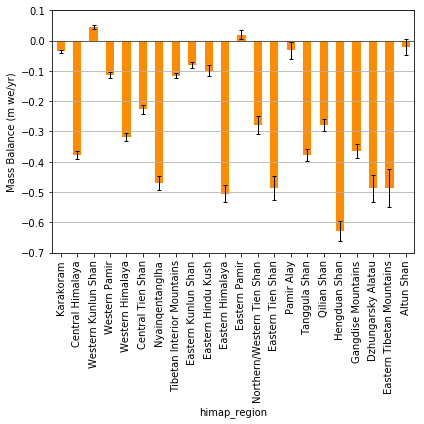

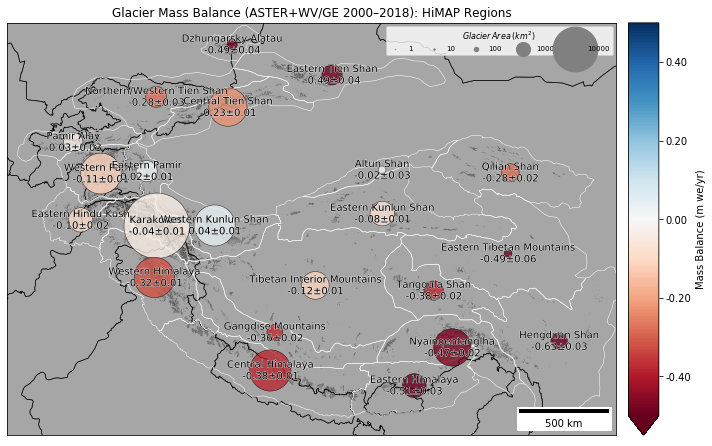

In [834]:
extent = [-1610900, -1142400, 1767400, 1145700]
title = suptitle + ": HiMAP Regions"
glac_gdf_mb_hex_region_agg = hex_agg(glac_gdf_mb_hex, region_df, region_col)
#hex_agg_plot(glac_gdf_mb_hex_region_agg, region_df, title, out_fn_suffix='_hex_himap_region_Gta')
hex_agg_plot(glac_gdf_mb_hex_region_agg, region_df, title, col=('mb_mwea', 'sum', 'sum'),sigma_col=('mb_mwea_sigma', 'sum', 'rss'), out_fn_suffix='_hex_himap_region_mwea')

In [379]:
glac_gdf_mb_hex_region_agg['mb_m3wea','sum','size']

himap_region
Karakoram                    153.00
Central Himalaya             173.00
Western Kunlun Shan          129.00
Western Pamir                156.00
Western Himalaya             213.00
Central Tien Shan            120.00
Nyainqentanglha              187.00
Tibetan Interior Mountains   157.00
Eastern Kunlun Shan          131.00
Eastern Hindu Kush           102.00
Eastern Himalaya              95.00
Eastern Pamir                 49.00
Northern/Western Tien Shan   123.00
Eastern Tien Shan             68.00
Pamir Alay                    72.00
Tanggula Shan                 81.00
Qilian Shan                   99.00
Hengduan Shan                106.00
Gangdise Mountains           141.00
Dzhungarsky Alatau            26.00
Eastern Tibetan Mountains     26.00
Altun Shan                    15.00
Name: (mb_m3wea, sum, size), dtype: float64

One-time spatial join by hex
(2415, 61)
Plotting borders
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'sum', 'sum') values
Adding annotations


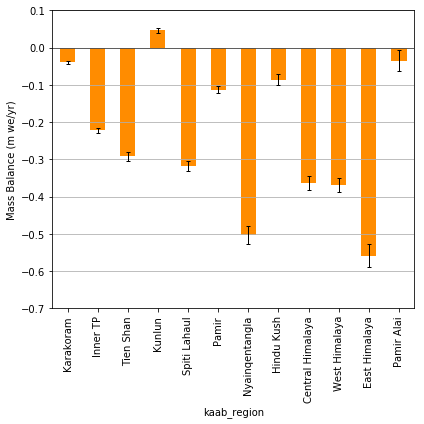

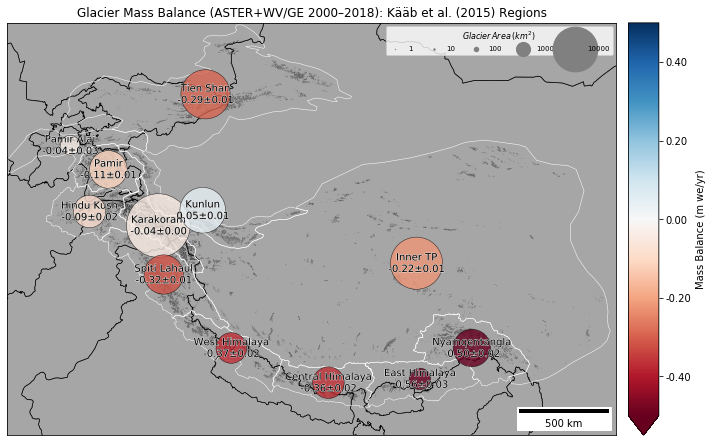

In [318]:
extent = [-1610900, -1142400, 1767400, 1145700]
title = suptitle + ": Kääb et al. (2015) Regions"
glac_gdf_mb_hex_region_agg = hex_agg(glac_gdf_mb_hex, kaab_region_df, kaab_region_col)
#hex_agg_plot(glac_gdf_mb_hex_region_agg, kaab_region_df, title, out_fn_suffix='_hex_kaab_region_Gta')
hex_agg_plot(glac_gdf_mb_hex_region_agg, kaab_region_df, title, col=('mb_mwea', 'sum', 'sum'),sigma_col=('mb_mwea_sigma', 'sum', 'rss'), out_fn_suffix='_hex_kaab_region_mwea')

## Basin aggregation and excess meltwater

In [257]:
basin_melt_gt_clim = (-5, 5)
extent = [-2396534,-2619071,3273634,2008000]
title = suptitle + ": WBM Basins"
out_fn_suffix = '_hex_basin_Gta'
glac_gdf_mb_hex_basin_agg = hex_agg(glac_gdf_mb_hex, basin_df, basin_col)
#hex_agg_plot(glac_gdf_mb_hex_basin_agg, basin_df, title, out_fn_suffix, clim=basin_melt_gt_clim)

One-time spatial join by hex
(2422, 63)
Index([                ('area_m2', 'mean'),
                        ('area_m2', 'sum'),
                       ('mb_mwea', 'mean'),
                     ('mb_mwea', 'median'),
                        ('mb_mwea', 'std'),
                        ('mb_mwea', 'sum'),
                       ('mb_mwea', 'size'),
                 ('mb_mwea_sigma', 'mean'),
                  ('mb_mwea_sigma', 'sum'),
                  ('mb_mwea_sigma', 'rss'),
                      ('mb_m3wea', 'mean'),
                    ('mb_m3wea', 'median'),
                       ('mb_m3wea', 'sum'),
                ('mb_m3wea_sigma', 'mean'),
                 ('mb_m3wea_sigma', 'sum'),
                 ('mb_m3wea_sigma', 'rss'),
                 ('mb_m3wea_sigma', 'rms'),
                         ('mb_Gta', 'sum'),
                  ('mb_Gta_sigma', 'mean'),
                   ('mb_Gta_sigma', 'sum'),
                   ('mb_Gta_sigma', 'rss'),
                   ('mb_Gta_sigma', 

Need to aggregate original 25-km cells over union of all ENDO basins for proper RSS uncertainty

In [739]:
glac_gdf_mb_hex_basin_agg['mb_m3wea','sum','sum']/1E9

basin_name
Indus                            -3.46
Tarim                            -1.01
Brahmaputra                      -5.02
Amu_Darya                        -1.02
Ganges                           -3.14
Inner_Tibetan_Plateau            -1.07
Ili                              -1.82
Inner_Tibetan_Plateau_Extended   -0.70
Syr_Darya                        -0.34
Yangtze                          -0.57
Salween                          -0.68
Mekong                           -0.07
Yellow                           -0.03
Irrawady                         -0.02
Name: (mb_m3wea, sum, sum), dtype: float64

In [738]:
glac_gdf_mb_hex_basin_agg['mb_m3wea_sigma','sum','rss']/1E9

basin_name
Indus                            0.16
Tarim                            0.13
Brahmaputra                      0.18
Amu_Darya                        0.09
Ganges                           0.12
Inner_Tibetan_Plateau            0.05
Ili                              0.10
Inner_Tibetan_Plateau_Extended   0.04
Syr_Darya                        0.06
Yangtze                          0.03
Salween                          0.04
Mekong                           0.01
Yellow                           0.01
Irrawady                         0.01
Name: (mb_m3wea_sigma, sum, rss), dtype: float64

In [380]:
glac_gdf_mb_hex_basin_agg['mb_m3wea','sum','size']

basin_name
Indus                            460.00
Tarim                            360.00
Brahmaputra                      338.00
Amu_Darya                        224.00
Ganges                           153.00
Inner_Tibetan_Plateau            246.00
Ili                              127.00
Inner_Tibetan_Plateau_Extended   157.00
Syr_Darya                        131.00
Yangtze                          104.00
Salween                           83.00
Mekong                            19.00
Yellow                            12.00
Irrawady                           8.00
Name: (mb_m3wea, sum, size), dtype: float64

In [740]:
glac_gdf_mb_hex_basin_agg['meltwater','total_m3a','sum']/1E9

basin_name
Indus                            -4.51
Tarim                            -2.56
Brahmaputra                      -5.40
Amu_Darya                        -1.32
Ganges                           -3.21
Inner_Tibetan_Plateau            -1.25
Ili                              -1.88
Inner_Tibetan_Plateau_Extended   -0.75
Syr_Darya                        -0.46
Yangtze                          -0.59
Salween                          -0.69
Mekong                           -0.07
Yellow                           -0.03
Irrawady                         -0.02
Name: (meltwater, total_m3a, sum), dtype: float64

In [741]:
glac_gdf_mb_hex_basin_agg['meltwater','total_m3a_sigma','rss']/1E9

basin_name
Indus                            0.12
Tarim                            0.09
Brahmaputra                      0.15
Amu_Darya                        0.06
Ganges                           0.11
Inner_Tibetan_Plateau            0.04
Ili                              0.09
Inner_Tibetan_Plateau_Extended   0.04
Syr_Darya                        0.04
Yangtze                          0.03
Salween                          0.04
Mekong                           0.01
Yellow                           0.01
Irrawady                         0.01
Name: (meltwater, total_m3a_sigma, rss), dtype: float64

In [734]:
basin_sum = glac_gdf_mb_hex_basin_agg.sum()
basin_sum/1E9

mb_m3wea_sigma       sum              sum     10.54
                                      rss      1.03
                                      rms      0.08
mb_m3wea             sum              sum    -18.98
                                      size     0.00
Area_all             sum              sum      0.00
meltwater            total_m3a        sum    -22.74
                     total_m3a_sigma  sum      8.00
                                      rss      0.84
                                      rms      0.06
centroid_x                                     0.01
centroid_y                                    -0.00
mb_Gta               sum              sum     -0.00
mb_Gta_sigma         sum              rss      0.00
meltwater_Gta        sum              sum     -0.00
meltwater_Gta_sigma  sum              rss      0.00
ENDO                                           0.00
dtype: float64

In [363]:
print('%0.2f\u00b1%0.2f Gt/yr' % (basin_sum[('meltwater_Gta', 'sum','sum')], \
                                  basin_sum[('meltwater_Gta_sigma','sum','rss')]))

-22.74±0.84 Gt/yr


In [733]:
#Exohreic basins
endo_sum = glac_gdf_mb_hex_basin_agg[glac_gdf_mb_hex_basin_agg['ENDO'] == 0].sum()
endo_sum/1E9

mb_m3wea_sigma       sum              sum      5.86
                                      rss      0.56
                                      rms      0.04
mb_m3wea             sum              sum    -13.01
                                      size     0.00
Area_all             sum              sum      0.00
meltwater            total_m3a        sum    -14.53
                     total_m3a_sigma  sum      4.78
                                      rss      0.48
                                      rms      0.04
centroid_x                                     0.01
centroid_y                                    -0.01
mb_Gta               sum              sum     -0.00
mb_Gta_sigma         sum              rss      0.00
meltwater_Gta        sum              sum     -0.00
meltwater_Gta_sigma  sum              rss      0.00
ENDO                                           0.00
dtype: float64

In [364]:
print('%0.2f\u00b1%0.2f Gt/yr' % (endo_sum[('meltwater_Gta', 'sum','sum')], \
                                  endo_sum[('meltwater_Gta_sigma','sum','rss')]))

-14.53±0.48 Gt/yr


In [353]:
endo_sum['mb_Gta','sum','sum']/Gt2mm

-0.035879383621371025

In [356]:
endo_sum['mb_Gta_sigma','sum','rss']/Gt2mm

0.001540227148954454

In [735]:
18.0*glac_gdf_mb_hex_basin_agg[glac_gdf_mb_hex_basin_agg['ENDO'] == 0].sum()/1E9

mb_m3wea_sigma       sum              sum     105.41
                                      rss      10.05
                                      rms       0.75
mb_m3wea             sum              sum    -234.11
                                      size      0.00
Area_all             sum              sum       0.00
meltwater            total_m3a        sum    -261.49
                     total_m3a_sigma  sum      85.97
                                      rss       8.58
                                      rms       0.67
centroid_x                                      0.13
centroid_y                                     -0.12
mb_Gta               sum              sum      -0.00
mb_Gta_sigma         sum              rss       0.00
meltwater_Gta        sum              sum      -0.00
meltwater_Gta_sigma  sum              rss       0.00
ENDO                                            0.00
dtype: float64

In [275]:
basin_summary = glac_gdf_mb_hex_basin_agg[[('mb_Gta','sum','sum'),('mb_Gta_sigma','sum','rss'),\
                          ('meltwater_Gta','sum','sum'),('meltwater_Gta_sigma','sum','rss')]]
basin_summary['ENDO'] = glac_gdf_mb_hex_basin_agg['ENDO']
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'_hex_basin_summary.pkl'
basin_summary.to_pickle(out_fn)

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


One-time spatial join by hex
(2422, 63)
Index([                ('area_m2', 'mean'),
                        ('area_m2', 'sum'),
                       ('mb_mwea', 'mean'),
                     ('mb_mwea', 'median'),
                        ('mb_mwea', 'std'),
                        ('mb_mwea', 'sum'),
                       ('mb_mwea', 'size'),
                 ('mb_mwea_sigma', 'mean'),
                  ('mb_mwea_sigma', 'sum'),
                  ('mb_mwea_sigma', 'rss'),
                      ('mb_m3wea', 'mean'),
                    ('mb_m3wea', 'median'),
                       ('mb_m3wea', 'sum'),
                ('mb_m3wea_sigma', 'mean'),
                 ('mb_m3wea_sigma', 'sum'),
                 ('mb_m3wea_sigma', 'rss'),
                 ('mb_m3wea_sigma', 'rms'),
                         ('mb_Gta', 'sum'),
                  ('mb_Gta_sigma', 'mean'),
                   ('mb_Gta_sigma', 'sum'),
                   ('mb_Gta_sigma', 'rss'),
                   ('mb_Gta_sigma', 

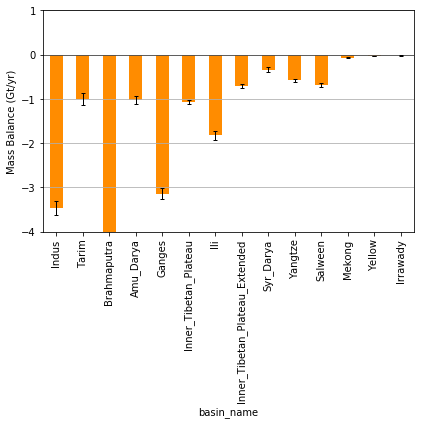

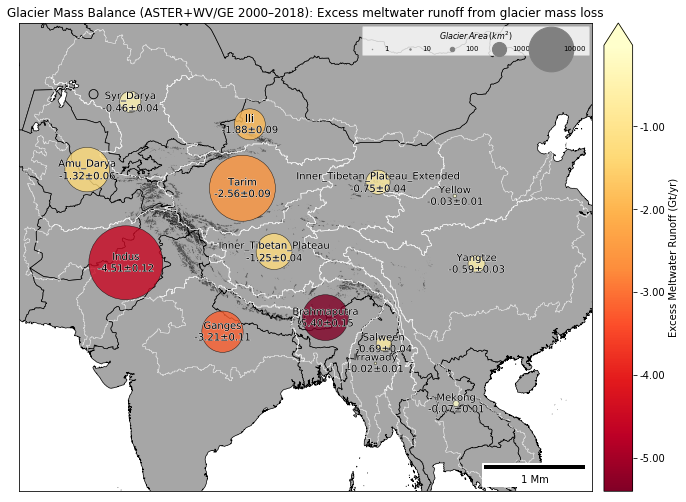

In [252]:
basin_melt_gt_clim = (-5, 0)
extent = [-2396534,-2619071,3273634,2008000]
title = suptitle + ": Excess meltwater runoff from glacier mass loss"
out_fn_suffix = '_hex_basin_excess_Gta'
glac_gdf_mb_hex_basin_agg = hex_agg(glac_gdf_mb_hex, basin_df, basin_col)
hex_agg_plot(glac_gdf_mb_hex_basin_agg, basin_df, title, out_fn_suffix, clim=basin_melt_gt_clim, col=('meltwater_Gta','sum','sum'), sigma_col=('meltwater_Gta_sigma','sum','rss'))

In [ ]:
glac_gdf_mb_hex_basin_agg

In [ ]:
basin_summary = glac_df_mb_basin[[('meltwater', 'count'),('meltwater', 'total_m3a'),('meltwater', 'total_Gta'),('meltwater', 'total_mmSLEa'), ('Area_all', 'sum')]]
display(basin_summary)
print(glac_df_mb_basin[[('meltwater', 'total_Gta'),('meltwater', 'total_mmSLEa')]].sum())
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'__%s_basin_summary.pkl' % dt_str
basin_summary.to_pickle(out_fn)

In [ ]:
#Mascons w/ uncertainties

Plotting borders
Plotting scatterplot of ('mb_Gta_sigma', 'sum', 'rss') values


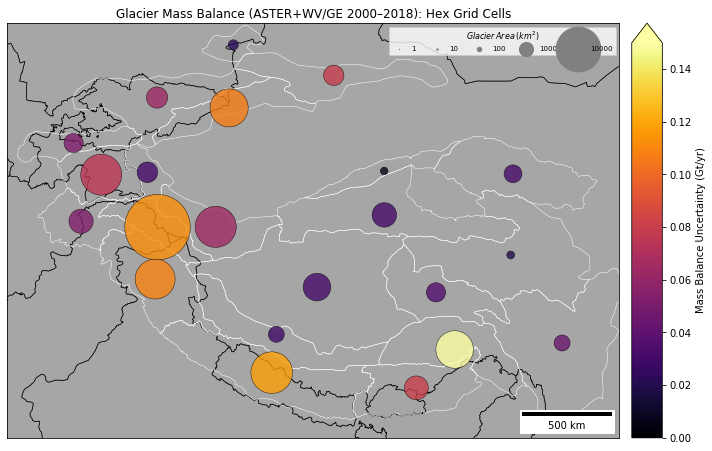

In [212]:
sigma_clim = (0,0.15)
hex_fig = make_map(col=('mb_Gta_sigma', 'sum', 'rss'), mb_dissolve_df=glac_gdf_mb_hex_region_agg, glac_df_mb=None, \
                   agg_df=region_df, border_df=border_df, clim=sigma_clim, crs=crs, extent=extent, labels=None, title=title)

# Original Analysis

In [42]:
if kaab_region_shp_fn is not None:
    glac_df_mb_kaab_region = spatial_aggregate(glac_df, glac_df_mb, kaab_region_df, kaab_region_col)

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [43]:
if region_shp_fn is not None:
    glac_df_mb_region = spatial_aggregate(glac_df, glac_df_mb, region_df, region_col)

In [44]:
glac_df_mb_kaab_region.iloc[1]

(area_m2, mean)                        767,280.46
(area_m2, sum)                  13,485,721,385.91
(mb_mwea, mean)                             -0.20
(mb_mwea, median)                           -0.17
(mb_mwea, std)                               0.30
(mb_mwea, sum)                          -3,567.17
(mb_mwea, size)                         17,576.00
(mb_mwea_sigma, mean)                        0.20
(mb_mwea_sigma, sum)                     3,568.61
(mb_mwea_sigma, rss)                        31.34
(mb_m3wea, mean)                      -171,623.83
(mb_m3wea, median)                     -23,864.06
(mb_m3wea, sum)                 -3,016,460,417.07
(mb_m3wea_sigma, mean)                  76,562.39
(mb_m3wea_sigma, sum)            1,345,660,622.78
(mb_m3wea_sigma, rss)               19,581,880.37
(mb_m3wea_sigma, rms)                  147,704.72
(mb_Gta, sum)                               -3.02
(mb_Gta_sigma, mean)                         0.00
(mb_Gta_sigma, sum)                          1.35


In [45]:
glac_df_mb_kaab_region[[('Area_all', 'sum'),('mb_Gta', 'sum'),('mb_Gta_sigma', 'sum'),('mb_Gta', 'rss')]]

(Area_all, sum)  (mb_Gta, sum)  (mb_Gta_sigma, sum)  \
kaab_region                                                             
Karakoram               20,237.82          -0.81                 1.03   
Inner TP                13,536.96          -3.02                 1.35   
Tien Shan               12,099.78          -3.53                 1.80   
Kunlun                  10,419.00           0.49                 0.67   
Spiti Lahaul             7,743.00          -2.46                 1.01   
Pamir                    7,097.66          -0.80                 0.58   
Nyainqentangla           6,944.06          -3.51                 1.46   
Hindu Kush               5,324.42          -0.45                 0.69   
Central Himalaya         4,969.56          -1.81                 0.61   
West Himalaya            4,655.70          -1.72                 0.64   
East Himalaya            2,354.86          -1.30                 0.39   
Pamir Alai               1,917.29          -0.07                 0.33   

                  (mb_Gta, rss)  
kaab_region                      
Karakoram                  0.03  
Inner TP                   0.02  
Tien Shan                  0.03  
Kunlun                     0.02  
Spiti Lahaul               0.02  
Pamir                      0.02  
Nyainqentangla             0.04  
Hindu Kush                 0.01  
Central Himalaya           0.02  
West Himalaya              0.02  
East Himalaya              0.02  
Pamir Alai                 0.01

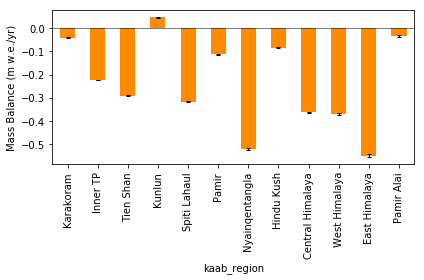

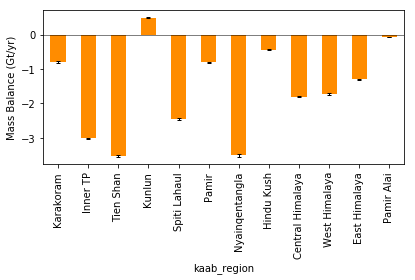

In [46]:
mb_tot = glac_df_mb_kaab_region[('mb_m3wea', 'sum')]
DOF=1
#err = glac_df_mb_kaab_region[('mb_m3wea_sigma', 'sum')]/DOF
err = glac_df_mb_kaab_region[('mb_m3wea_sigma', 'rss')]

fig, ax = plt.subplots()
(mb_tot/glac_df_mb_kaab_region[('area_m2', 'sum')]).plot.bar(yerr=err/glac_df_mb_kaab_region[('area_m2', 'sum')], ax=ax, color='darkorange', error_kw=dict(ecolor='k', lw=1, capsize=2, capthick=1))
ax.axhline(0, color='k', lw=0.5)
ax.set_ylabel('Mass Balance (m w.e./yr)')
plt.tight_layout()
fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_mwea_bar.png'
fig.savefig(fig_fn, dpi=300, pad_inches=0) 

fig, ax = plt.subplots()
(mb_tot/1E9).plot.bar(yerr=err/1E9, ax=ax, color='darkorange', error_kw=dict(ecolor='k', lw=1, capsize=2, capthick=1))
ax.axhline(0, color='k', lw=0.5)
ax.set_ylabel('Mass Balance (Gt/yr)')
plt.tight_layout()
fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_Gta_bar.png'
fig.savefig(fig_fn, dpi=300, pad_inches=0) 

In [69]:
if mascon_shp_fn is not None:
    glac_df_mb_mascon = spatial_aggregate(glac_df, glac_df_mb, mascon_df, mascon_col)

if qdgc_shp_fn is not None:
    glac_df_mb_qdgc = spatial_aggregate(glac_df, glac_df_mb, qdgc_df, qdgc_col)
    
if basin_shp_fn is not None:
    glac_df_mb_basin = spatial_aggregate(glac_df, glac_df_mb, basin_df, basin_col)
    glac_df_mb_basin_exo = glac_df_mb_basin[glac_df_mb_basin['ENDO'] == 0]

In [48]:
#Compile stats for all glaciers
#specific mass balance rate and total mass change  
all_stats = glac_df_mb[['mb_mwea','mb_m3wea']].mean()
#all_stats = glac_df_mb[['mb_mwea','mb_m3wea']].median()
all_stats['mb_mwea_std'] = glac_df_mb[['mb_mwea','mb_mwea']].std()
all_stats['mb_m3wea_std'] = glac_df_mb[['mb_mwea','mb_m3wea']].std()
#glac_df_mb[['mb_mwea','mb_m3wea']].apply(malib.mad, axis=0)
#all_stats = glac_df_mb[['mb_mwea']].mean()
#Total sampled area
all_stats['sample_area'] = glac_df_mb['Area'].sum()
#All area in RGI db
all_stats['RGI_total_area'] = glac_df['Area'].sum()
all_stats['sample_area_perc'] = all_stats['sample_area']/all_stats['RGI_total_area']
all_stats['mb_m3wea_sum'] = glac_df_mb['mb_m3wea'].sum()
all_stats['mb_m3wea_sigma_mean'] = glac_df_mb['mb_m3wea_sigma'].mean()
all_stats['mb_m3wea_sigma_rss'] = rss(glac_df_mb['mb_m3wea_sigma'])
all_stats['mb_m3wea_sigma_rms'] = rms(glac_df_mb['mb_m3wea_sigma'])
all_stats['mb_m3wea_sigma_sum'] = glac_df_mb['mb_m3wea_sigma'].sum()
all_stats['mb_m3wea_all'] = all_stats['mb_mwea'] * all_stats['RGI_total_area'] * 1E6
all_stats['mb_Gta'] = all_stats['mb_m3wea']/1E9
all_stats['mb_Gta_sum'] = all_stats['mb_m3wea_sum']/1E9
all_stats['mb_Gta_sigma_rss'] = all_stats['mb_m3wea_sigma_rss']/1E9
all_stats['mb_Gta_sigma_rms'] = all_stats['mb_m3wea_sigma_rms']/1E9
all_stats['mb_Gta_all'] = all_stats['mb_m3wea_all']/1E9
all_stats['mma_SLR'] = all_stats['mb_Gta_sum']/Gt2mm

print(all_stats['mb_m3wea_sum']/(all_stats['sample_area']*1E6))
print(all_stats['mb_m3wea_sigma_rss']/(all_stats['sample_area']*1E6))

dt = glac_df_mb['dt'].mean()
all_stats_cum = all_stats * dt

print("All glaciers, rate")
print(all_stats)
#print("All glaciers, cumulative")
#print(all_stats_cum)

-0.19561664177615776
0.0008308595210740239
All glaciers, rate
mb_mwea                                                            -0.18
mb_m3wea                                                     -200,933.53
mb_mwea_std                 mb_mwea   0.38
mb_mwea   0.38
dtype: float64
mb_m3wea_std           mb_mwea            0.38
mb_m3wea   1,664,001.5...
sample_area                                                    97,002.78
RGI_total_area                                                 97,300.12
sample_area_perc                                                    1.00
mb_m3wea_sum                                          -18,975,358,849.02
mb_m3wea_sigma_mean                                           111,620.81
mb_m3wea_sigma_rss                                         80,595,686.66
mb_m3wea_sigma_rms                                            262,266.61
mb_m3wea_sigma_sum                                     10,541,023,129.20
mb_m3wea_all                                          -17,689,

In [49]:
L = 500
n = len(glac_df_mb)
#sigma_rms = all_stats['mb_m3wea_sigma_rms']
#np.sqrt(n)*(5**2)*sigma_rms/1E9
#np.sqrt(n)*sigma_rms/1E9

In [50]:
n = 30
all_stats['mb_m3wea_sigma_sum']/1E9/np.sqrt(n)

1.9245187156829082

In [51]:
region_stats = [('mb_mwea', 'count'),('mb_mwea', 'mean'),('mb_mwea', 'std'),('Area', 'sum'),('Area_all', 'sum'),('Area', 'perc'),('mb_mwea', 'total_Gta'), ('mb_Gta', 'sum'), ('mb_Gta', 'rss')]

kaab_region_summary = glac_df_mb_kaab_region[region_stats]
display(kaab_region_summary)
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'__%s_kaab_region_summary.pkl' % dt_str
kaab_region_summary.to_pickle(out_fn)

region_summary = glac_df_mb_region[region_stats]
display(region_summary)
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'__%s_region_summary.pkl' % dt_str
region_summary.to_pickle(out_fn)



#Compile stats for each division
print("\nTotal Gt/a for each aggregation")
print('agg', 'total_Gta', 'mb_mwea')
for i in [glac_df_mb_basin, glac_df_mb_region, glac_df_mb_qdgc]:
    print(i.df_name, i[('mb_Gta', 'sum')].sum(), i['mb_mwea', 'mean'].mean())

if False:
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    print("Loading shaded relief map")
    hs_ds = gdal.Open(hs_fn)
    hs = iolib.ds_getma(hs_ds)
    hs_extent = geolib.ds_extent(hs_ds)
    hs_extent_cartopy = cartopy_extent(hs_extent)
    print("Plotting image")
    ax.imshow(hs, cmap='gray', origin='upper', extent=hs_extent_cartopy, transform=crs, alpha=0.6)
else:
    hs = None

"""
#This is currently broken
import cartopy.feature as cfeature
borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none')
ax.add_feature(borders, edgecolor='k')
"""

(mb_mwea, count)  (mb_mwea, mean)  (mb_mwea, std)  \
kaab_region                                                           
Karakoram                    10279            -0.02            0.30   
Inner TP                     17576            -0.20            0.30   
Tien Shan                    14314            -0.28            0.42   
Kunlun                        6639             0.12            0.23   
Spiti Lahaul                  9956            -0.20            0.26   
Pamir                         7081            -0.06            0.20   
Nyainqentangla                7278            -0.46            0.60   
Hindu Kush                    7430            -0.05            0.32   
Central Himalaya              3896            -0.36            0.32   
West Himalaya                 4347            -0.32            0.33   
East Himalaya                 2239            -0.50            0.39   
Pamir Alai                    3401            -0.03            0.31   

                  (Area, sum)  (Area_all, sum)  (Area, perc)  \
kaab_region                                                    
Karakoram           20,229.01        20,237.82         99.96   
Inner TP            13,485.70        13,536.96         99.62   
Tien Shan           12,097.05        12,099.78         99.98   
Kunlun              10,415.62        10,419.00         99.97   
Spiti Lahaul         7,741.51         7,743.00         99.98   
Pamir                7,097.05         7,097.66         99.99   
Nyainqentangla       6,727.96         6,944.06         96.89   
Hindu Kush           5,324.23         5,324.42        100.00   
Central Himalaya     4,960.26         4,969.56         99.81   
West Himalaya        4,654.18         4,655.70         99.97   
East Himalaya        2,353.88         2,354.86         99.96   
Pamir Alai           1,916.34         1,917.29         99.95   

                  (mb_mwea, total_Gta)  (mb_Gta, sum)  (mb_Gta, rss)  
kaab_region                                                           
Karakoram                        -0.34          -0.81           0.03  
Inner TP                         -2.75          -3.02           0.02  
Tien Shan                        -3.44          -3.53           0.03  
Kunlun                            1.20           0.49           0.02  
Spiti Lahaul                     -1.52          -2.46           0.02  
Pamir                            -0.41          -0.80           0.02  
Nyainqentangla                   -3.20          -3.51           0.04  
Hindu Kush                       -0.27          -0.45           0.01  
Central Himalaya                 -1.79          -1.81           0.02  
West Himalaya                    -1.49          -1.72           0.02  
East Himalaya                    -1.19          -1.30           0.02  
Pamir Alai                       -0.06          -0.07           0.01

(mb_mwea, count)  (mb_mwea, mean)  (mb_mwea, std)  \
himap_region                                                                    
Karakoram                              11528            -0.00            0.34   
Central Himalaya                        7310            -0.35            0.32   
Western Kunlun Shan                     5666             0.11            0.22   
Western Pamir                           9083            -0.06            0.20   
Western Himalaya                        9841            -0.20            0.27   
Central Tien Shan                       5832            -0.20            0.39   
Nyainqentanglha                         7249            -0.42            0.59   
Tibetan Interior Mountains              3478            -0.09            0.19   
Eastern Kunlun Shan                     3083            -0.02            0.25   
Eastern Hindu Kush                      4359            -0.08            0.26   
Eastern Himalaya                        2665            -0.49            0.40   
Northern/Western Tien Shan              3895            -0.24            0.38   
Eastern Pamir                           1582             0.03            0.21   
Eastern Tien Shan                       3688            -0.41            0.48   
Pamir Alay                              3146            -0.03            0.32   
Tanggula Shan                           1581            -0.35            0.31   
Qilian Shan                             2681            -0.25            0.25   
Hengduan Shan                           1993            -0.58            0.36   
Gangdise Mountains                      3833            -0.24            0.26   
Dzhungarsky Alatau                       968            -0.44            0.34   
Eastern Tibetan Mountains                509            -0.51            0.42   
Altun Shan                               466            -0.03            0.18   

                            (Area, sum)  (Area_all, sum)  (Area, perc)  \
himap_region                                                             
Karakoram                     21,466.66        21,475.66         99.96   
Central Himalaya               8,658.11         8,668.87         99.88   
Western Kunlun Shan            8,452.57         8,455.74         99.96   
Western Pamir                  8,420.22         8,420.83         99.99   
Western Himalaya               7,967.11         7,968.60         99.98   
Central Tien Shan              7,269.26         7,270.83         99.98   
Nyainqentanglha                6,826.79         7,044.99         96.90   
Tibetan Interior Mountains     3,807.36         3,816.98         99.75   
Eastern Kunlun Shan            2,990.88         2,995.00         99.86   
Eastern Hindu Kush             2,932.63         2,932.63        100.00   
Eastern Himalaya               2,844.71         2,845.70         99.97   
Northern/Western Tien Shan     2,260.31         2,261.28         99.96   
Eastern Pamir                  2,117.72         2,117.72        100.00   
Eastern Tien Shan              2,064.35         2,064.54         99.99   
Pamir Alay                     1,845.07         1,846.03         99.95   
Tanggula Shan                  1,836.83         1,840.74         99.79   
Qilian Shan                    1,597.55         1,597.59        100.00   
Hengduan Shan                  1,252.13         1,277.58         98.01   
Gangdise Mountains             1,267.76         1,270.65         99.77   
Dzhungarsky Alatau               520.88           520.88        100.00   
Eastern Tibetan Mountains        308.79           312.14         98.93   
Altun Shan                       295.08           295.16         99.97   

                            (mb_mwea, total_Gta)  (mb_Gta, sum)  (mb_Gta, rss)  
himap_region                                                                    
Karakoram                                  -0.02          -0.77           0.03  
Central Himalaya                           -3.00          -3.25

(meltwater, count)  (meltwater, total_m3a)  \
basin_name                                                                   
Indus                                        15999       -4,517,100,722.39   
Tarim                                         7940       -2,516,167,875.13   
Brahmaputra                                   9756       -5,347,943,006.36   
Amu_Darya                                     7591       -1,357,949,562.92   
Ganges                                        6028       -3,154,709,634.29   
Inner_Tibetan_Plateau                         3388       -1,166,812,154.15   
Ili                                           5593       -1,755,848,520.47   
Inner_Tibetan_Plateau_Extended                3121         -773,122,002.29   
Syr_Darya                                     3053         -556,178,059.97   
Yangtze                                       1367         -675,425,643.28   
Salween                                       2105         -768,922,031.52   
Mekong                                         324          -79,026,158.77   
Yellow                                         110          -33,355,506.95   
Irrawady                                       129          -33,129,432.01   

                                (meltwater, total_Gta)  \
basin_name                                               
Indus                                            -4.52   
Tarim                                            -2.52   
Brahmaputra                                      -5.35   
Amu_Darya                                        -1.36   
Ganges                                           -3.15   
Inner_Tibetan_Plateau                            -1.17   
Ili                                              -1.76   
Inner_Tibetan_Plateau_Extended                   -0.77   
Syr_Darya                                        -0.56   
Yangtze                                          -0.68   
Salween                                          -0.77   
Mekong                                           -0.08   
Yellow                                           -0.03   
Irrawady                                         -0.03   

                                (meltwater, total_mmSLEa)  (Area_all, sum)  
basin_name                                                                  
Indus                                               -0.01        27,295.00  
Tarim                                               -0.01        21,854.22  
Brahmaputra                                         -0.01        10,367.66  
Amu_Darya                                           -0.00        10,078.52  
Ganges                                              -0.01         8,426.07  
Inner_Tibetan_Plateau                               -0.00         6,334.99  
Ili                                                 -0.00         4,408.68  
Inner_Tibetan_Plateau_Extended                      -0.00         2,959.07  
Syr_Darya                                           -0.00         2,340.81  
Yangtze                                             -0.00         1,679.13  
Salween                                             -0.00         1,250.75  
Mekong                                              -0.00           198.68  
Yellow                                              -0.00            56.69  
Irrawady                                            -0.00            49.87

(meltwater, total_Gta)      -22.74
(meltwater, total_mmSLEa)    -0.06
dtype: float64

Exorheic Basins (SLR contribution)


(meltwater, count)  (meltwater, total_m3a)  \
basin_name                                                
Indus                     15999       -4,517,100,722.39   
Brahmaputra                9756       -5,347,943,006.36   
Ganges                     6028       -3,154,709,634.29   
Yangtze                    1367         -675,425,643.28   
Salween                    2105         -768,922,031.52   
Mekong                      324          -79,026,158.77   
Yellow                      110          -33,355,506.95   
Irrawady                    129          -33,129,432.01   

             (meltwater, total_Gta)  (meltwater, total_mmSLEa)  
basin_name                                                      
Indus                         -4.52                      -0.01  
Brahmaputra                   -5.35                      -0.01  
Ganges                        -3.15                      -0.01  
Yangtze                       -0.68                      -0.00  
Salween                       -0.77                      -0.00  
Mekong                        -0.08                      -0.00  
Yellow                        -0.03                      -0.00  
Irrawady                      -0.03                      -0.00

(meltwater, total_Gta)      -14.61
(meltwater, total_mmSLEa)    -0.04
dtype: float64

Total Gt/a for each aggregation
agg total_Gta mb_mwea
basin_name -18.97535884901799 -0.3031722602217072
himap_region -18.975358849017994 -0.2202520247001697
qdgc -18.975358849018 -0.2182991763935569


"\n#This is currently broken\nimport cartopy.feature as cfeature\nborders = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none')\nax.add_feature(borders, edgecolor='k')\n"

In [52]:
if True:
    mascon_df_out = glac_df_mb_mascon[[('mb_mwea','count'),('mb_mwea', 'mean'), ('mb_mwea', 'std'), ('Area','sum'),('mb_Gta', 'sum'), ('Area_all', 'sum'), ('mb_mwea', 'total_Gta')]]
    header = ('n_glaciers','mb_mwea_mean','mb_mwea_std','obs_glacier_area_km2','mb_Gta_sum','all_glacier_area_km2','mb_Gta_all')
    mascon_csv_fn = os.path.splitext(glac_shp_join_fn)[0]+'_mascon.csv'
    mascon_df_out.to_csv(mascon_csv_fn, float_format='%0.2f',header=header)

In [53]:
map_plots=True

In [54]:
if border_shp_fn is not None:
    print("Loading borders")
    #Load local copy of border polygons
    border_df = gpd.read_file(border_shp_fn)
    border_df = border_df.to_crs(glac_df.crs)

Loading borders


Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_basin_excess_Gt_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('meltwater', 'total_Gta') values
Adding annotations
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_basin_excess_Gt_fig.png


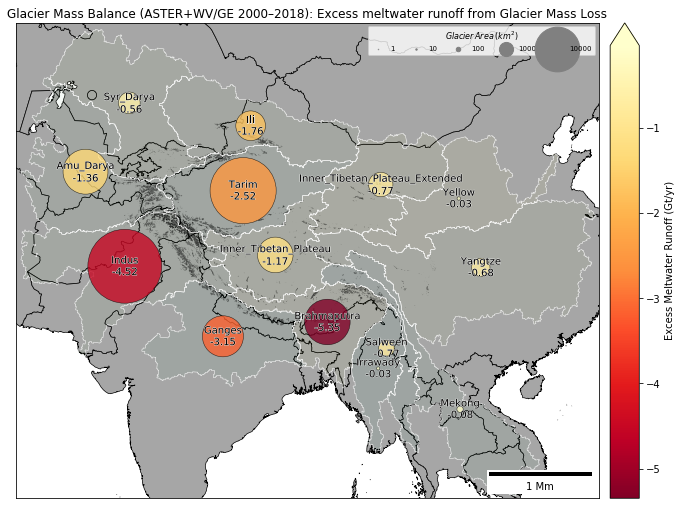

In [69]:
if map_plots and basin_shp_fn is not None:
    basin_melt_gt_clim = (-5, 0)
    basin_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_basin_excess_Gt_fig.png'
    print("Generating figure: %s" % basin_fig_fn)
    if basin_col == 'HYBAS_ID':
        title = suptitle + ": HydroBASINS level 4" 
    else:
        title = suptitle + ": Excess meltwater runoff from Glacier Mass Loss"
    #minx, miny, maxx, maxy
    basin_extent = [-2396534,-2619071, 3273634,2008000]
    #basin_extent = basin_df.total_bounds
    basin_fig = make_map(col=('meltwater', 'total_Gta'), mb_dissolve_df=glac_df_mb_basin, glac_df_mb=glac_df_mb, agg_df=basin_df, border_df=border_df, clim=basin_melt_gt_clim, crs=crs, extent=basin_extent, labels='name+val', title=title)
    #basin_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_basin, glac_df_mb=glac_df_mb, agg_df=basin_df, border_df=border_df, clim=None, crs=crs, extent=extent, labels='val', title=title)
    print("Saving figure: %s" % basin_fig_fn)
    #basin_fig.savefig(basin_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 
    basin_fig.savefig(basin_fig_fn, dpi=300, pad_inches=0) 

Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_basin_mwe_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Adding annotations
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_basin_mwe_fig.png


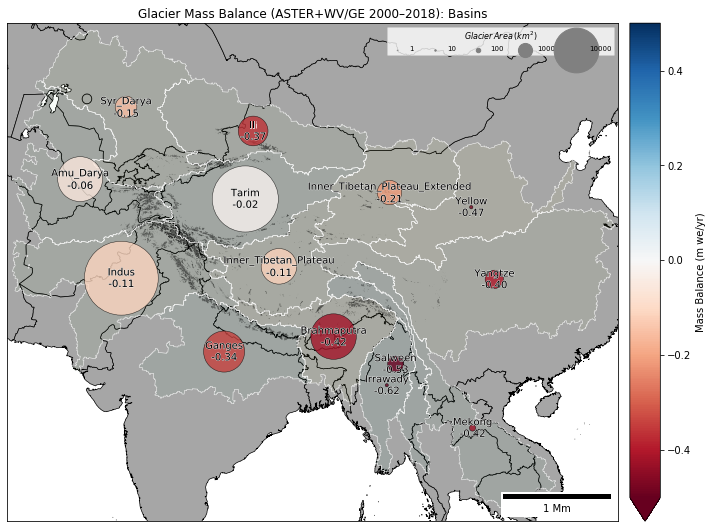

In [70]:
if map_plots and basin_shp_fn is not None:
    basin_mb_clim = (-0.5, 0.5)
    basin_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_basin_mwe_fig.png'
    print("Generating figure: %s" % basin_fig_fn)
    if basin_col == 'HYBAS_ID':
        title = suptitle + ": HydroBASINS level 4" 
    else:
        title = suptitle + ": Basins"
    #minx, miny, maxx, maxy
    basin_extent = [-2396534,-2619071, 3273634,2008000]
    basin_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_basin, glac_df_mb=glac_df_mb, agg_df=basin_df, border_df=border_df, clim=basin_mb_clim, crs=crs, extent=basin_extent, labels='name+val', title=title)
    print("Saving figure: %s" % basin_fig_fn)
    #basin_fig.savefig(basin_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 
    basin_fig.savefig(basin_fig_fn, dpi=300, pad_inches=0) 

In [ ]:
if map_plots and qdgc_shp_fn is not None:
    qdgc_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_qdgc_mwe_fig.png'
    print("Generating figure: %s" % qdgc_fig_fn)
    #To plot grid cells, pass agg_df=qdgc_df
    title = suptitle + ": Quarter-degree Grid Cells"
    qdgc_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_qdgc, glac_df_mb=glac_df_mb, agg_df=None, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels=None, title=title)
    print("Saving figure: %s" % qdgc_fig_fn)
    qdgc_fig.savefig(qdgc_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_kaab_region_Gt_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_Gta', 'sum') values
Adding annotations
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_kaab_region_Gt_fig.png
Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_kaab_region_mwe_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Adding annotations
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_kaab_region_mwe_fig.png


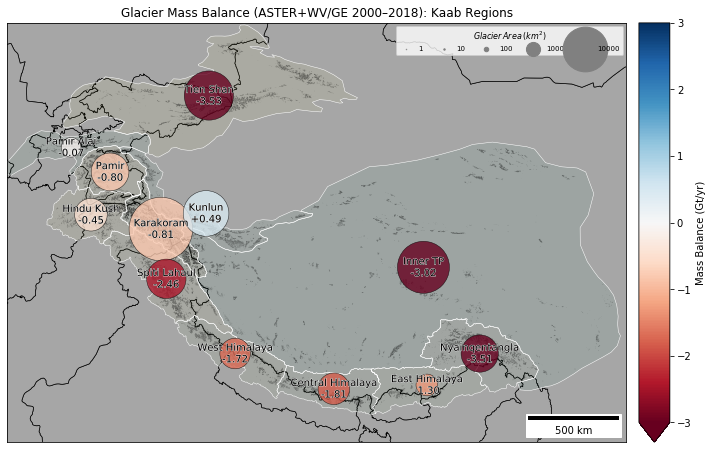

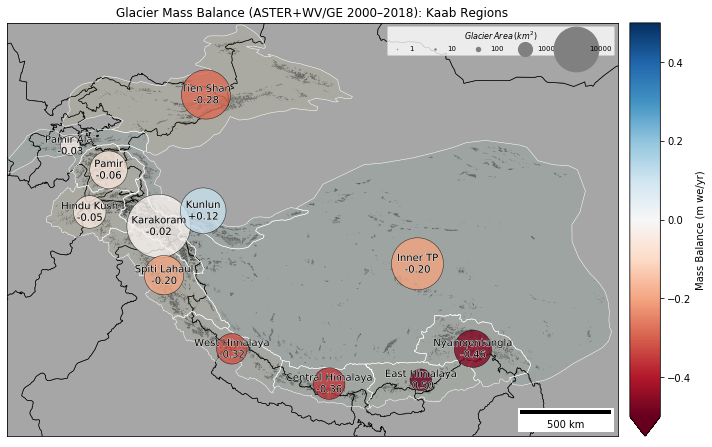

In [72]:
region_gt_clim = (-3.0, 3.0)
region_mb_clim=(-0.5, 0.5)

if map_plots and kaab_region_shp_fn is not None:
    kaab_region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_Gt_fig.png'
    print("Generating figure: %s" % kaab_region_fig_fn)
    title = suptitle + ": Kaab Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    kaab_region_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_kaab_region, glac_df_mb=glac_df_mb, agg_df=kaab_region_df, border_df=border_df, clim=region_gt_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % kaab_region_fig_fn)
    kaab_region_fig.savefig(kaab_region_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

    kaab_region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_mwe_fig.png'
    print("Generating figure: %s" % kaab_region_fig_fn)
    title = suptitle + ": Kaab Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    kaab_region_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_kaab_region, glac_df_mb=glac_df_mb, agg_df=kaab_region_df, border_df=border_df, clim=region_mb_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % kaab_region_fig_fn)
    kaab_region_fig.savefig(kaab_region_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_region_Gt_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_Gta', 'sum') values
Adding annotations
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_region_Gt_fig.png
Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_region_mwe_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Adding annotations
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_region_mwe_fig.png


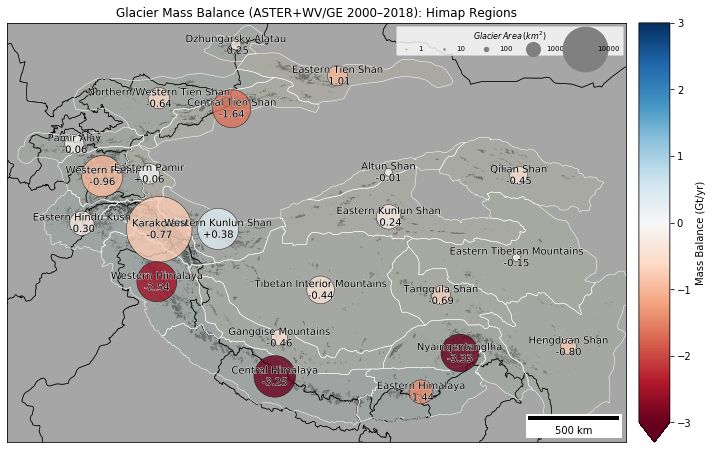

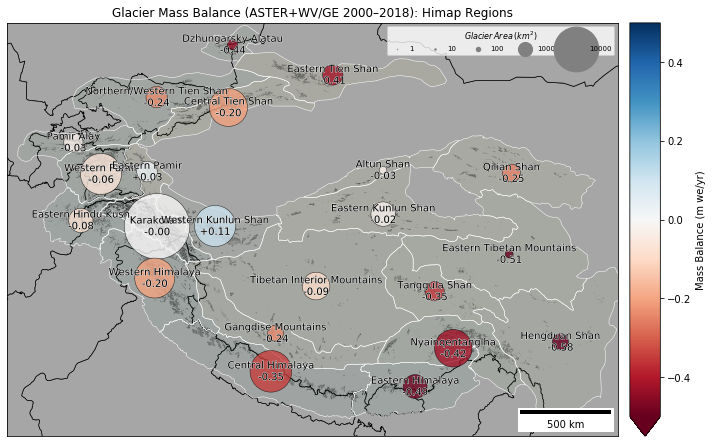

In [73]:
if map_plots and region_shp_fn is not None:
    region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_region_Gt_fig.png'
    print("Generating figure: %s" % region_fig_fn)
    title = suptitle + ": Himap Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    region_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=region_gt_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % region_fig_fn)
    region_fig.savefig(region_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

    region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_region_mwe_fig.png'
    print("Generating figure: %s" % region_fig_fn)
    title = suptitle + ": Himap Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    region_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=region_mb_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % region_fig_fn)
    region_fig.savefig(region_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_mascon_mwe_fig.png
Plotting borders
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_mascon_mwe_fig.png


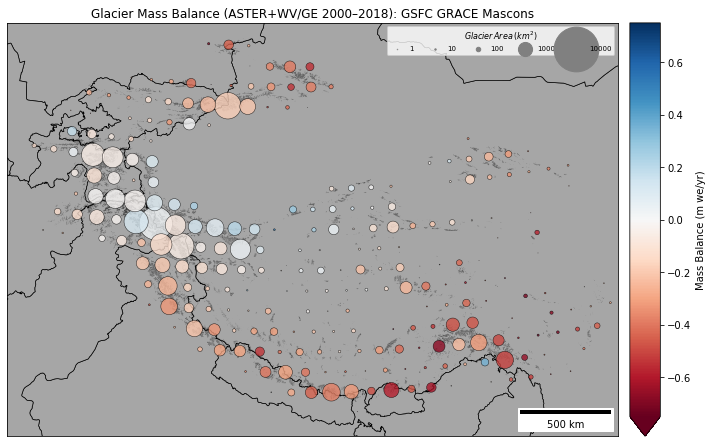

In [74]:
if map_plots and mascon_shp_fn is not None:
    mascon_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_mascon_mwe_fig.png'
    print("Generating figure: %s" % mascon_fig_fn)
    #To plot grid cells, pass agg_df=mascon_df
    title = suptitle + ": GSFC GRACE Mascons"
    mascon_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_mascon, glac_df_mb=glac_df_mb, agg_df=None, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels=None, title=title)
    print("Saving figure: %s" % mascon_fig_fn)
    mascon_fig.savefig(mascon_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

Generating figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_mascon_Gt_fig.png
Plotting borders
Plotting glacier polygons
Plotting scatterplot of ('mb_Gta', 'sum') values
Saving figure: /scr/hma/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean_rgi60_merge_HMA_aea_join_mascon_Gt_fig.png


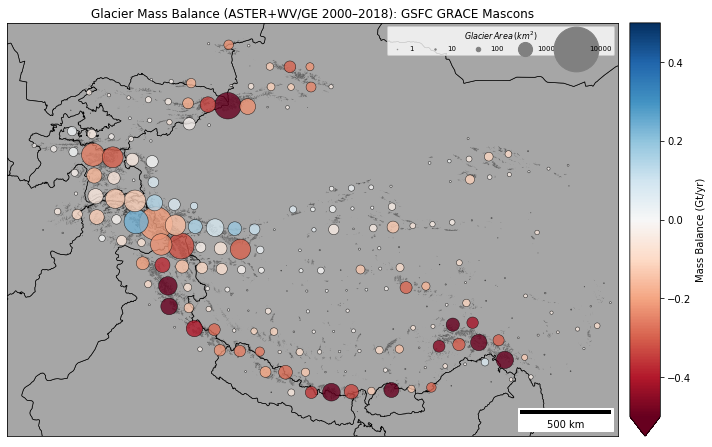

In [75]:
if map_plots and mascon_shp_fn is not None:
    mascon_gt_clim = (-0.5, 0.5)
    mascon_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_mascon_Gt_fig.png'
    print("Generating figure: %s" % mascon_fig_fn)
    #To plot grid cells, pass agg_df=mascon_df
    title = suptitle + ": GSFC GRACE Mascons"
    mascon_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_mascon, glac_df_mb=glac_df_mb, agg_df=None, border_df=border_df, clim=mascon_gt_clim, crs=crs, extent=extent, labels=None, title=title)
    print("Saving figure: %s" % mascon_fig_fn)
    mascon_fig.savefig(mascon_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 